In [28]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import preliz as pz
import pymc as pm

In [29]:
az.style.use('arviz-doc')

In [30]:
%%HTML
<style>

.CodeMirror {
    width: 100vw;
}

.container {
    width: 99% !important;
}

.rendered_html {
  font-size:0.8em;
}
.rendered_html table, .rendered_html th, .rendered_html tr, .rendered_html td {
     font-size: 100%;
}


body {
  font-family: Ubuntu;
  background: #F0F0F0;
  background-color: #F0F0F0;
}


.reveal h1,
.reveal h2,
.reveal h3,
.reveal h4,
.reveal h5,
.reveal h6 {
  margin: 0 0 20px 0;
  color: #2a2eec;
  font-family: Ubuntu;
  line-height: 0.9em;
  letter-spacing: 0.02em;
  text-transform: none;
  text-shadow: none;
}

.reveal blockquote {
  display: block;
  position: relative;
  background: #fa7c17;
  border-radius: 15px;
  box-shadow: 0px 0px 2px rgba(0, 0, 0, 0.2);
  font-weight: bold;
}

</style>

In [31]:
from traitlets.config.manager import BaseJSONConfigManager
path = "/home/osvaldo/anaconda3/etc/jupyter/nbconfig"
cm = BaseJSONConfigManager(config_dir=path)
cm.update("livereveal", {
              "theme": "serif",
              "transition": "zoom",
              "start_slideshow_at": "selected",
              "controls": "True",
              "progress": "False",
              "shortcut": "False"});

<center><img src="img/Logo_UNSAM.png" width="200">
<br>
<br>
<h1 align="center">Introducción a la programación probabilista</h1>    


<br>
<br>
<br>
<br>
<br>

## Objetivos

<br>
<br>

* Aprender a construir modelos simples con PyMC y a explorarlos con ArviZ


* Aprender sobre las pruebas predictivas a posteriori


* Comparar grupos en términos de tamaño del efecto (en oposición a la "significancia estadística")

## Programación probabilista

<br>


* Aunque conceptualmente simple, los modelos Bayesianos a menudo conducen a expresiones analíticamente intratables


* La *promesa de la programación probabilista* es la separación entre modelado e inferencia. Les practicantes deben centrarse en el modelado, no en *los detalles matemáticos / computacionales* necesarios para resolver los modelos.


* Los modelos se escriben en código y luego se compilan para obtener la distribución *a posteriori*


* Los motores de inferencia universal pueden resolver cualquier modelo probabilista (bueno, más o menos)

## Existen alternativas

<center><img src="img/disclaimer.png" width=200></center>

* La programación probabilista no es la única forma de abordar la estadística Bayesiana

* En algunos casos es posible resolver modelos de forma analítica

* En otros casos es posible construir métodos _ad-hoc_ de inferencia, especificos para un determinado modelo (esto suele ser una combinación de métodos analíticos y numéricos)

* Muchas personas que se consideran Bayesianas NO utilizan lenguajes de programación probabilista de forma rutinaria.


## PyMC: Programación probabilista en Python
<br>

<center><img src="img/PyMC.png" width=300></center>

* Construcción de modelos
    * Una gran colección de distribuciones de probabilidad
    * Una sintaxis simple, pero muy flexible
    * Integración con herramientas del ecosistema Python

* Inferencia
    * Markov Chain Monte Carlo (NUTS, MH)
    * Monte Carlo Secuencial (SMC, SMC-ABC)
    * Inferencia Variacional

In [32]:
n_experimentos = 4
theta_real = .35  # En casos reales este valor es desconocido
datos = pz.Binomial(1, theta_real).rvs(n_experimentos, random_state=123)
datos

array([1, 0, 0, 0])

In [33]:
with pm.Model() as nuestro_primer_modelo:
    θ = pm.Beta('θ', alpha=1, beta=1)  # a priori
    y = pm.Bernoulli('y', p=θ, observed=datos)  # likelihood
    
    idata = pm.sample(1000)  # MCMC, motor de inferencia universal

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [37]:
idata

<xarray.DataArray 'θ' ()> Size: 8B
array(0.17554367)

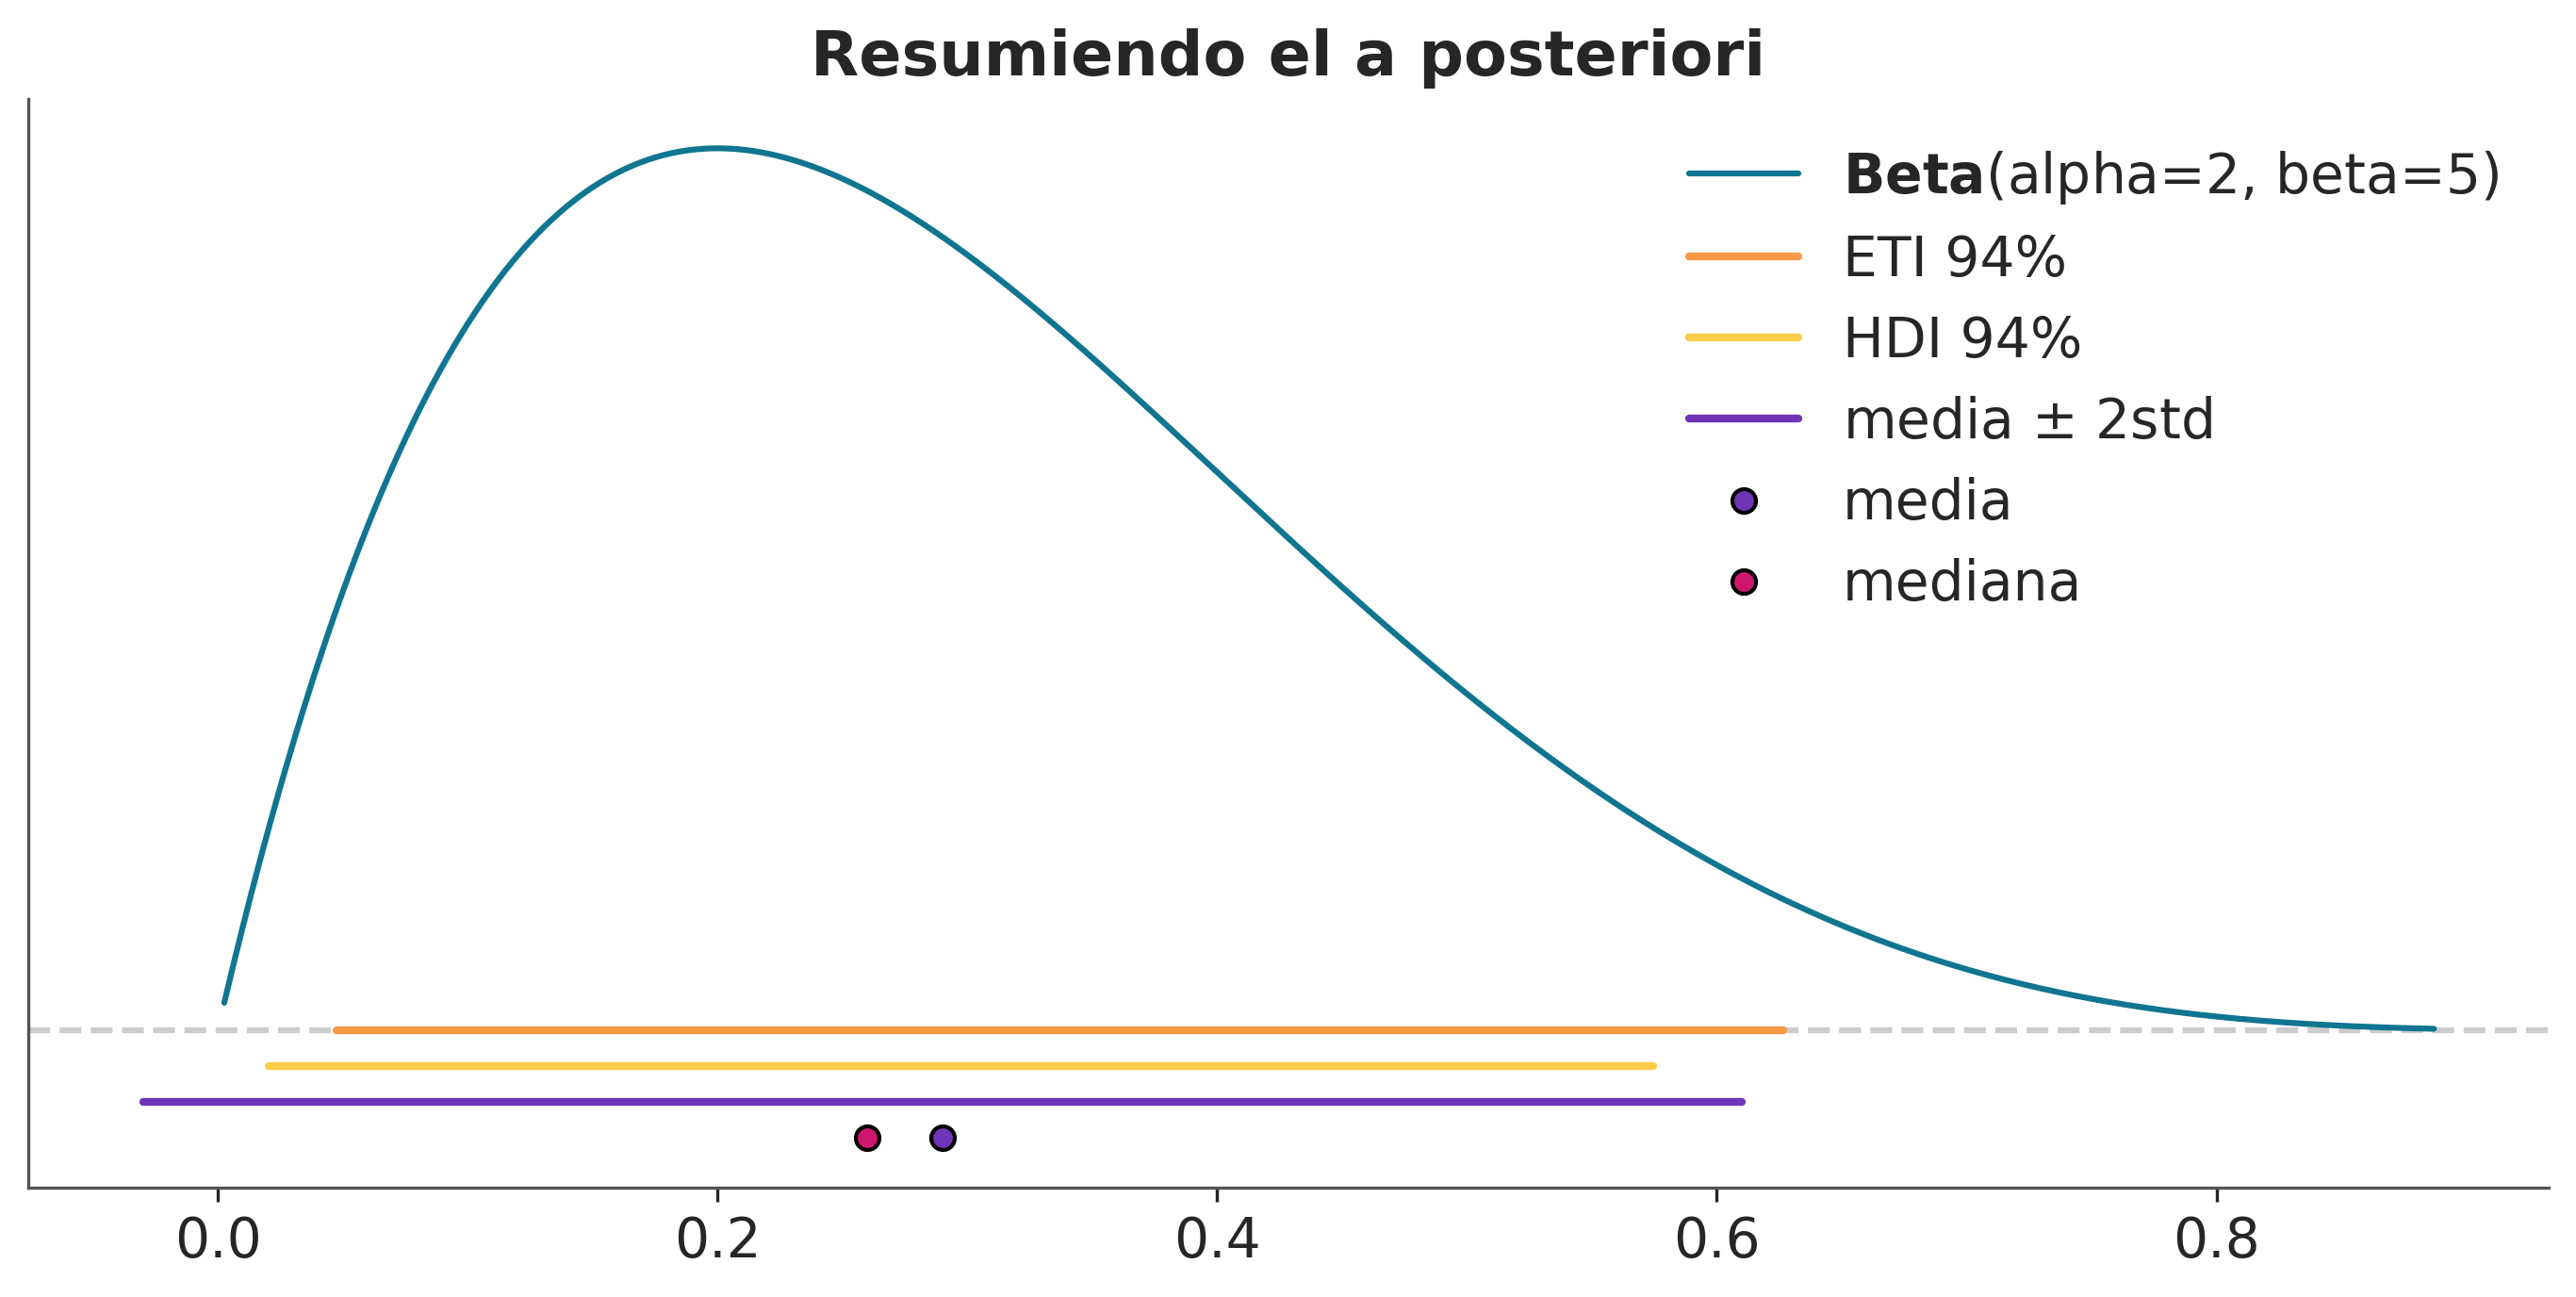

In [8]:
dist = pz.Beta(2, 5)
ax = dist.plot_pdf()
eti = dist.eti()
hdi = dist.hdi()
summary = dist.summary()
mean = summary.mean
median = summary.median
std = summary.std
ax.plot(eti, [0, 0], "C2", lw=2, label="ETI 94%")
ax.plot(hdi, [-0.1, -0.1], "C3", lw=2, label="HDI 94%")
ax.plot([mean-2*std, mean+2*std], [-0.2, -0.2], "C8", lw=2, label="media $\pm$ 2std")
ax.plot(mean, -0.3, "C8o", mec="k", label="media")
ax.plot(median, -0.3, "C9o", mec="k", label="mediana")
ax.set_title("Resumiendo el a posteriori")
ax.legend();

## ArviZ: Análisis exploratorio de modelos Bayesianos

<br>
<br>
<center><img src="img/arviz.png" width=300></center>
<br>

* Interpretar los resultados y prepararlos para una audiencia particular</font>
* <font color = "gray"> Diagnosticar la calidad de la inferencia
* <font color = "gray"> Criticar a los modelos, incluyendo la evaluación de los supuestos del modelo y de sus predicciones </font>
* <font color = "gray">Comparación de modelos, incluyendo la selección y promediado de modelos </font>

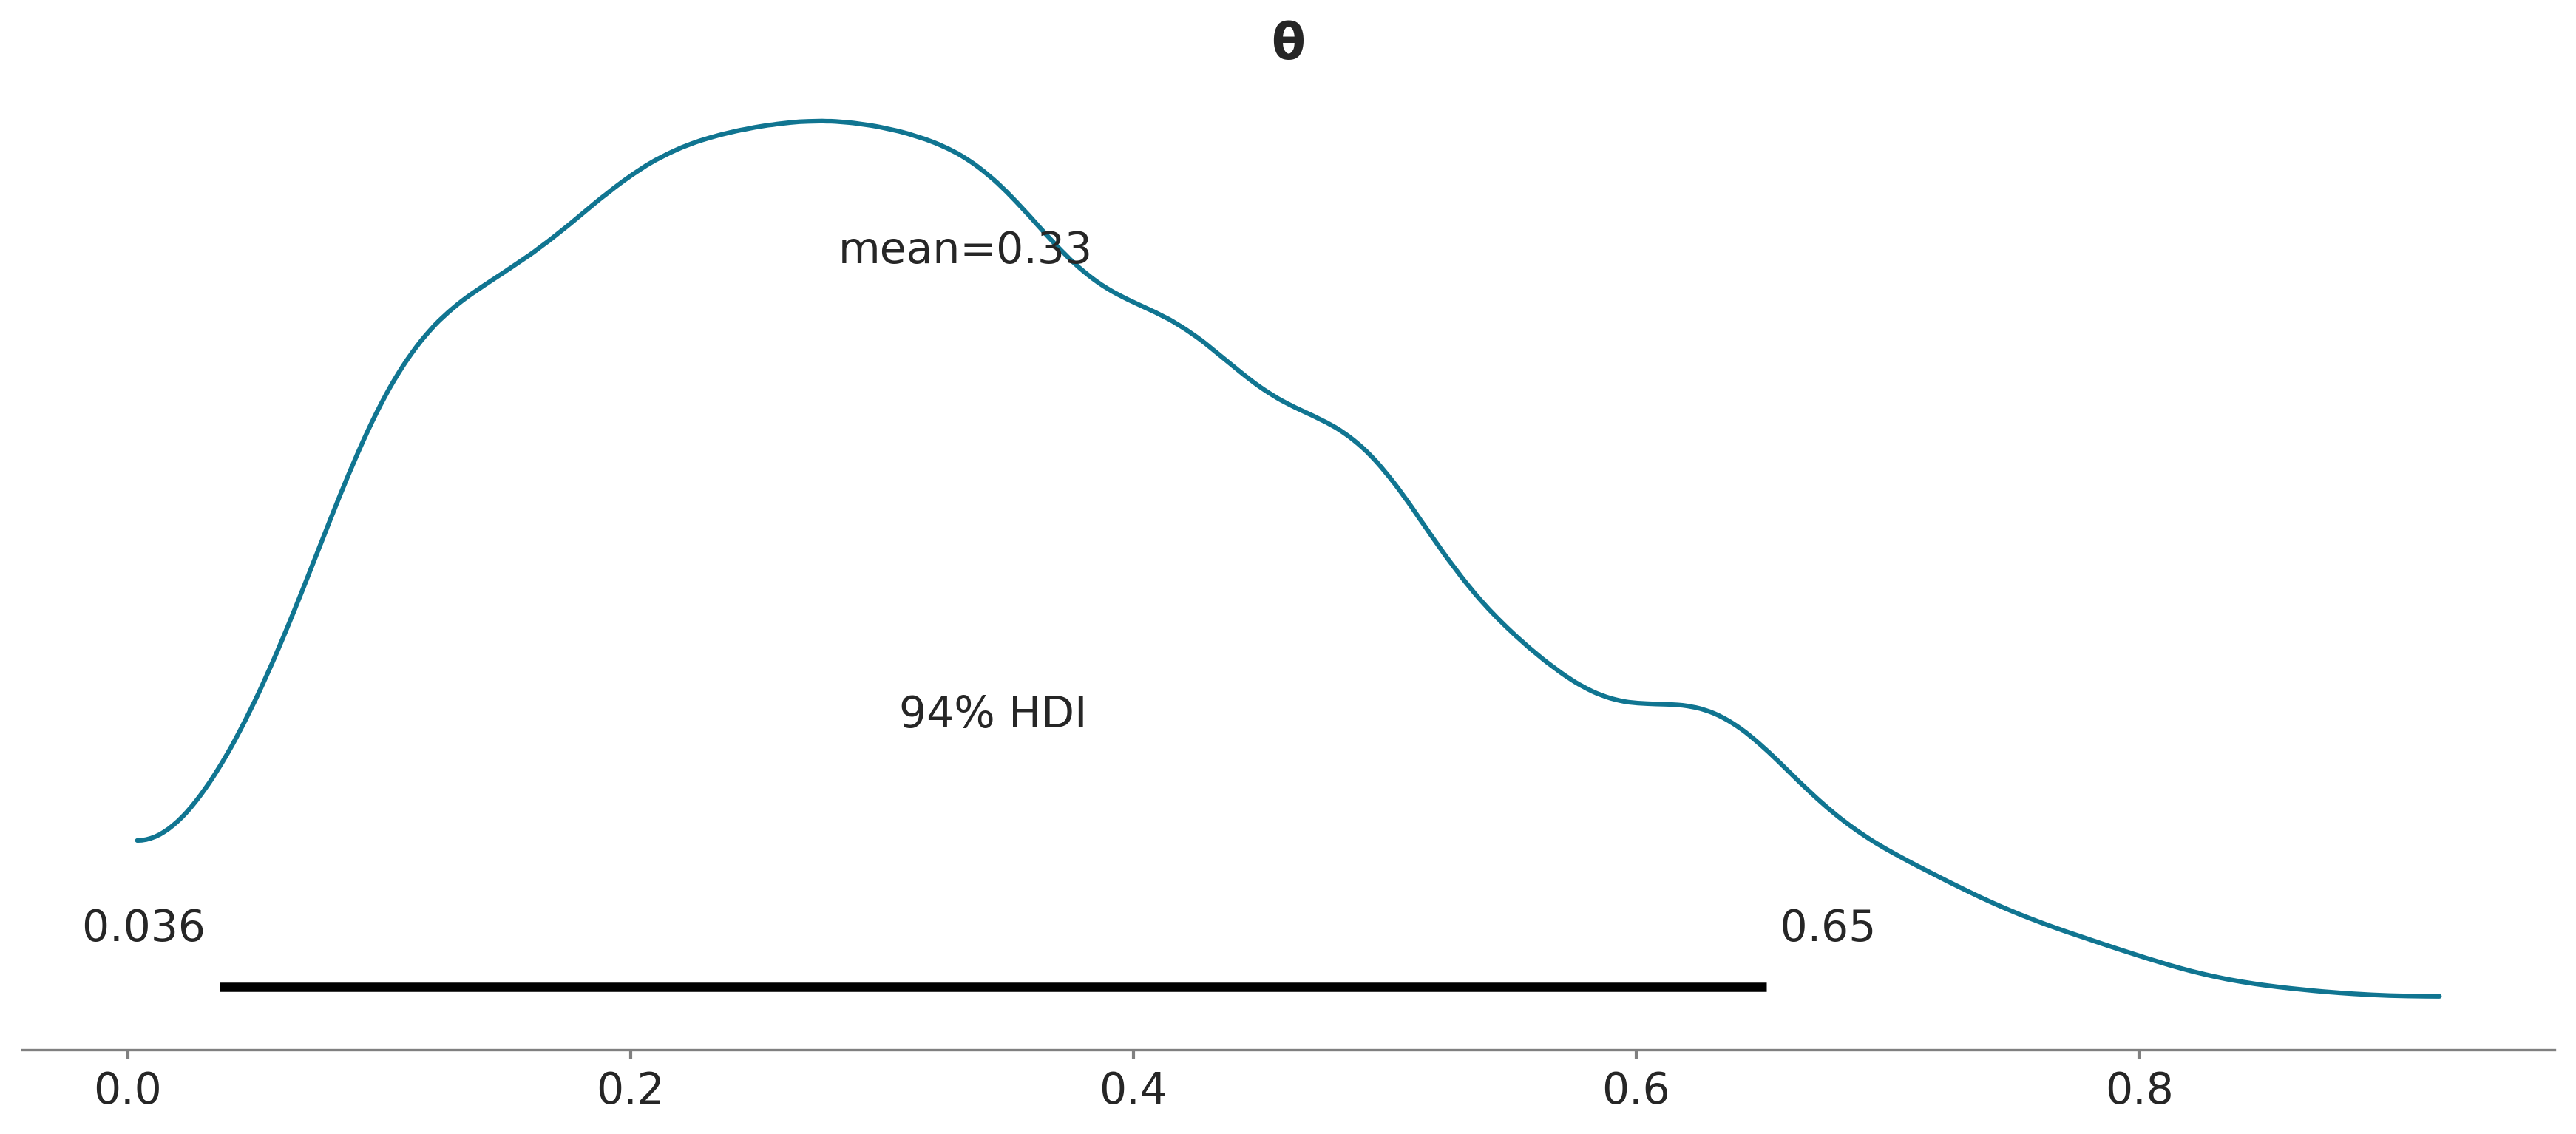

In [38]:
az.plot_posterior(idata);

In [10]:
az.summary(idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
θ,0.335,0.182,0.023,0.651


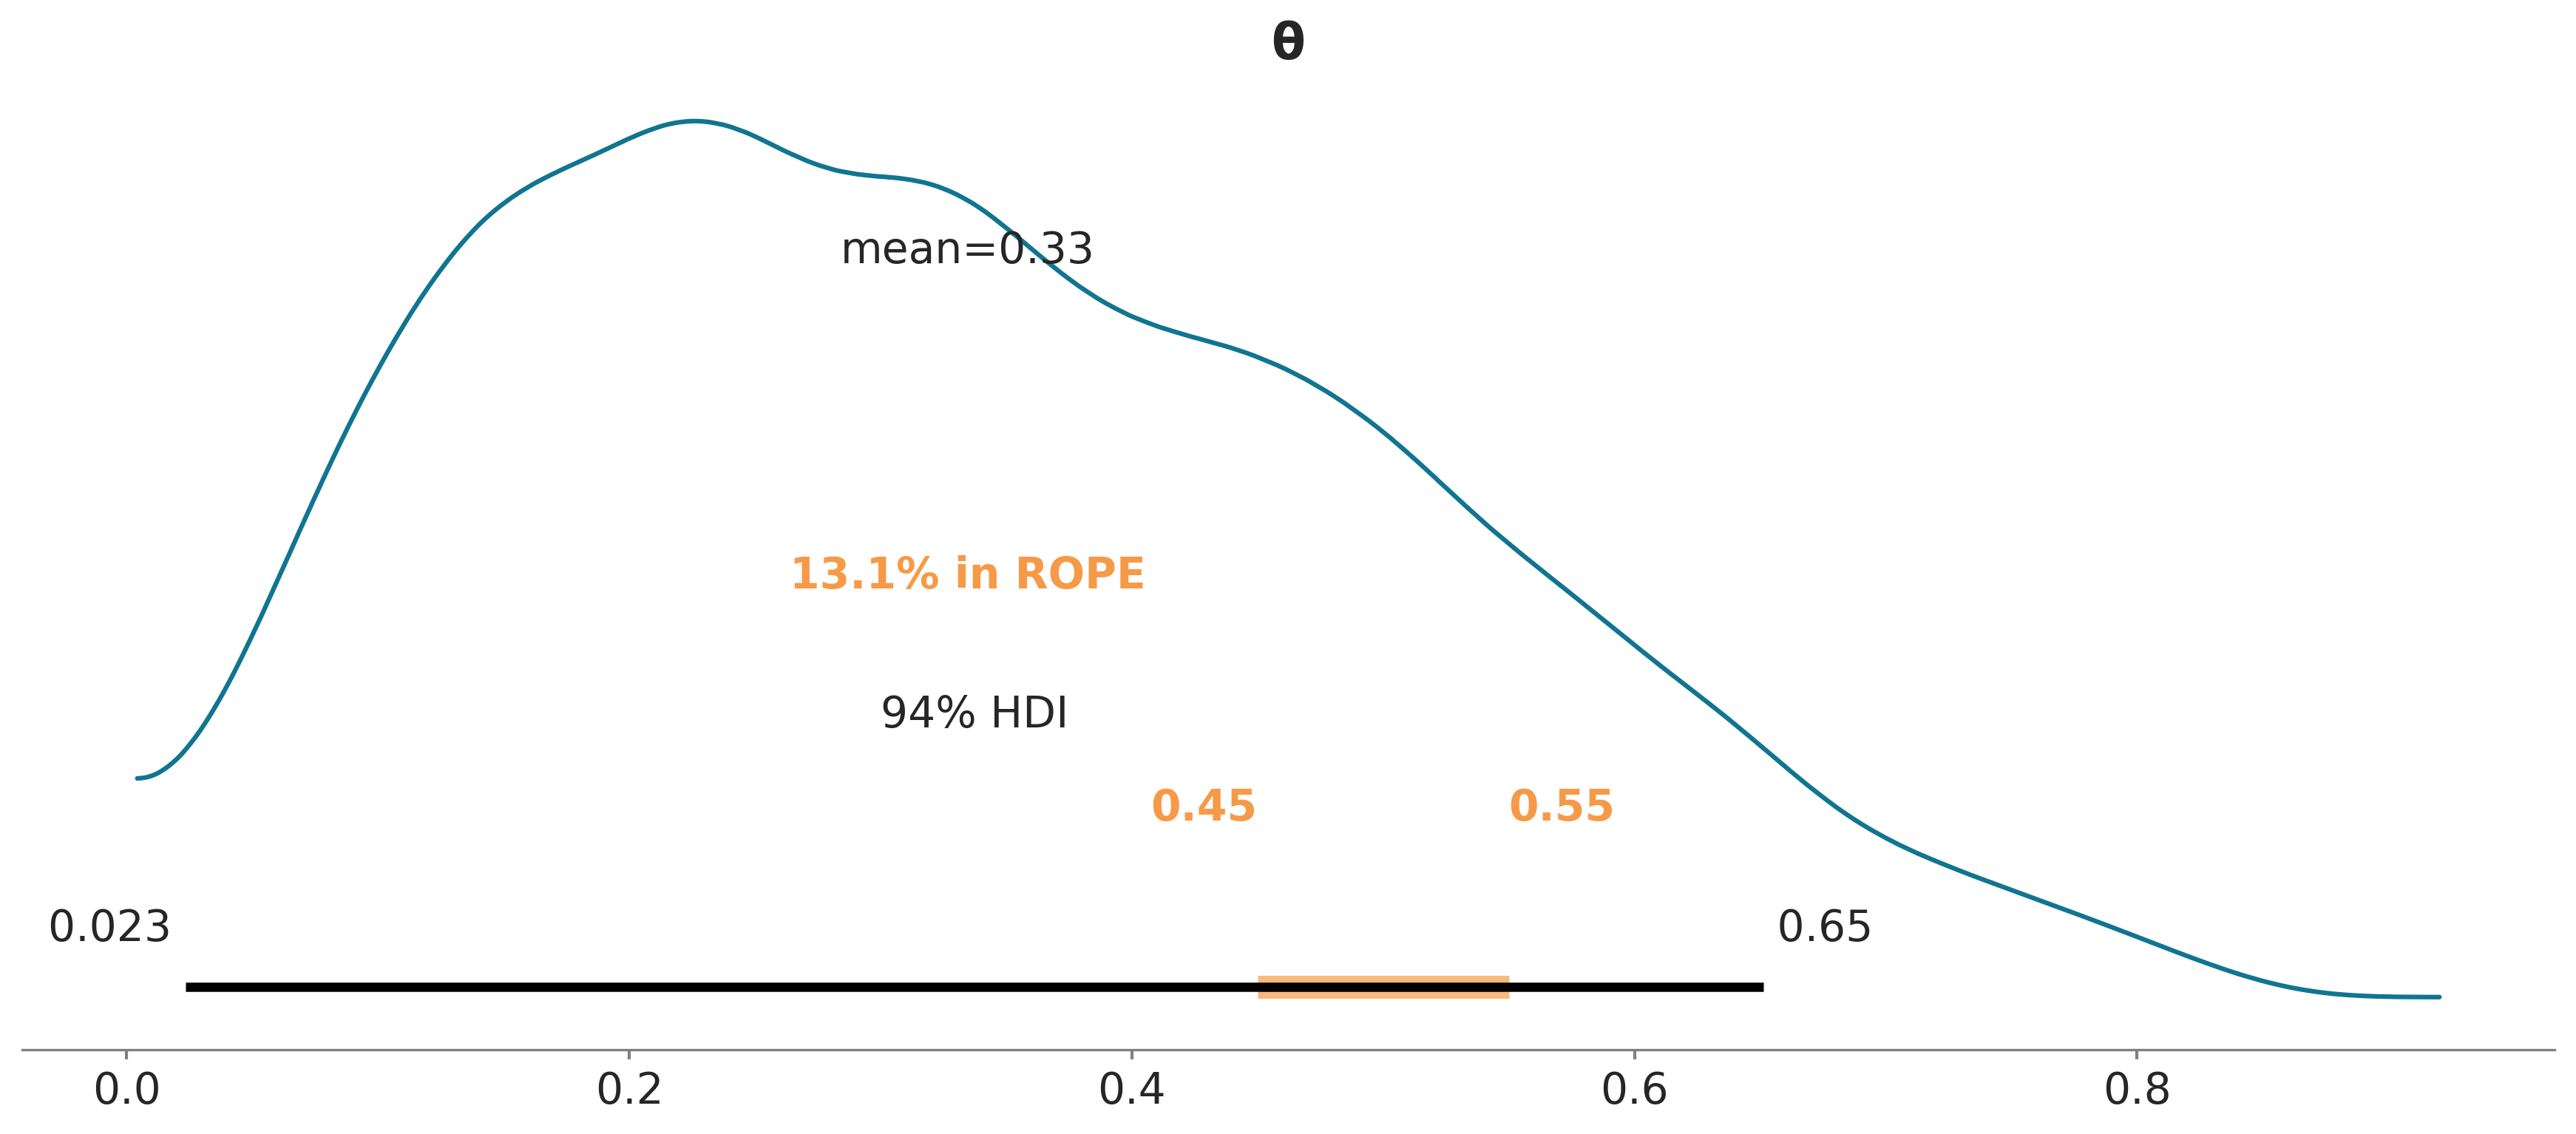

In [11]:
az.plot_posterior(idata, rope=[0.45, .55]); 

## El problema de los tanques alemanes

<br>

* Durante la segunda guerra mundial los aliados lograron recolectar números de series de tanques alemanes capturados

* Cómo estimar el número total de tanques alemanes a partir de esta información? 

In [40]:
números_serie = np.array([15, 18, 20, 42])

with pm.Model() as model:
    N = pm.DiscreteUniform('N',
                           lower=números_serie.max(), 
                           upper=números_serie.max()*10)
    
    y_obs = pm.DiscreteUniform('y_obs', lower=0, upper=N, observed=números_serie)

    idata = pm.sample(2000, random_seed=4239)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [N]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


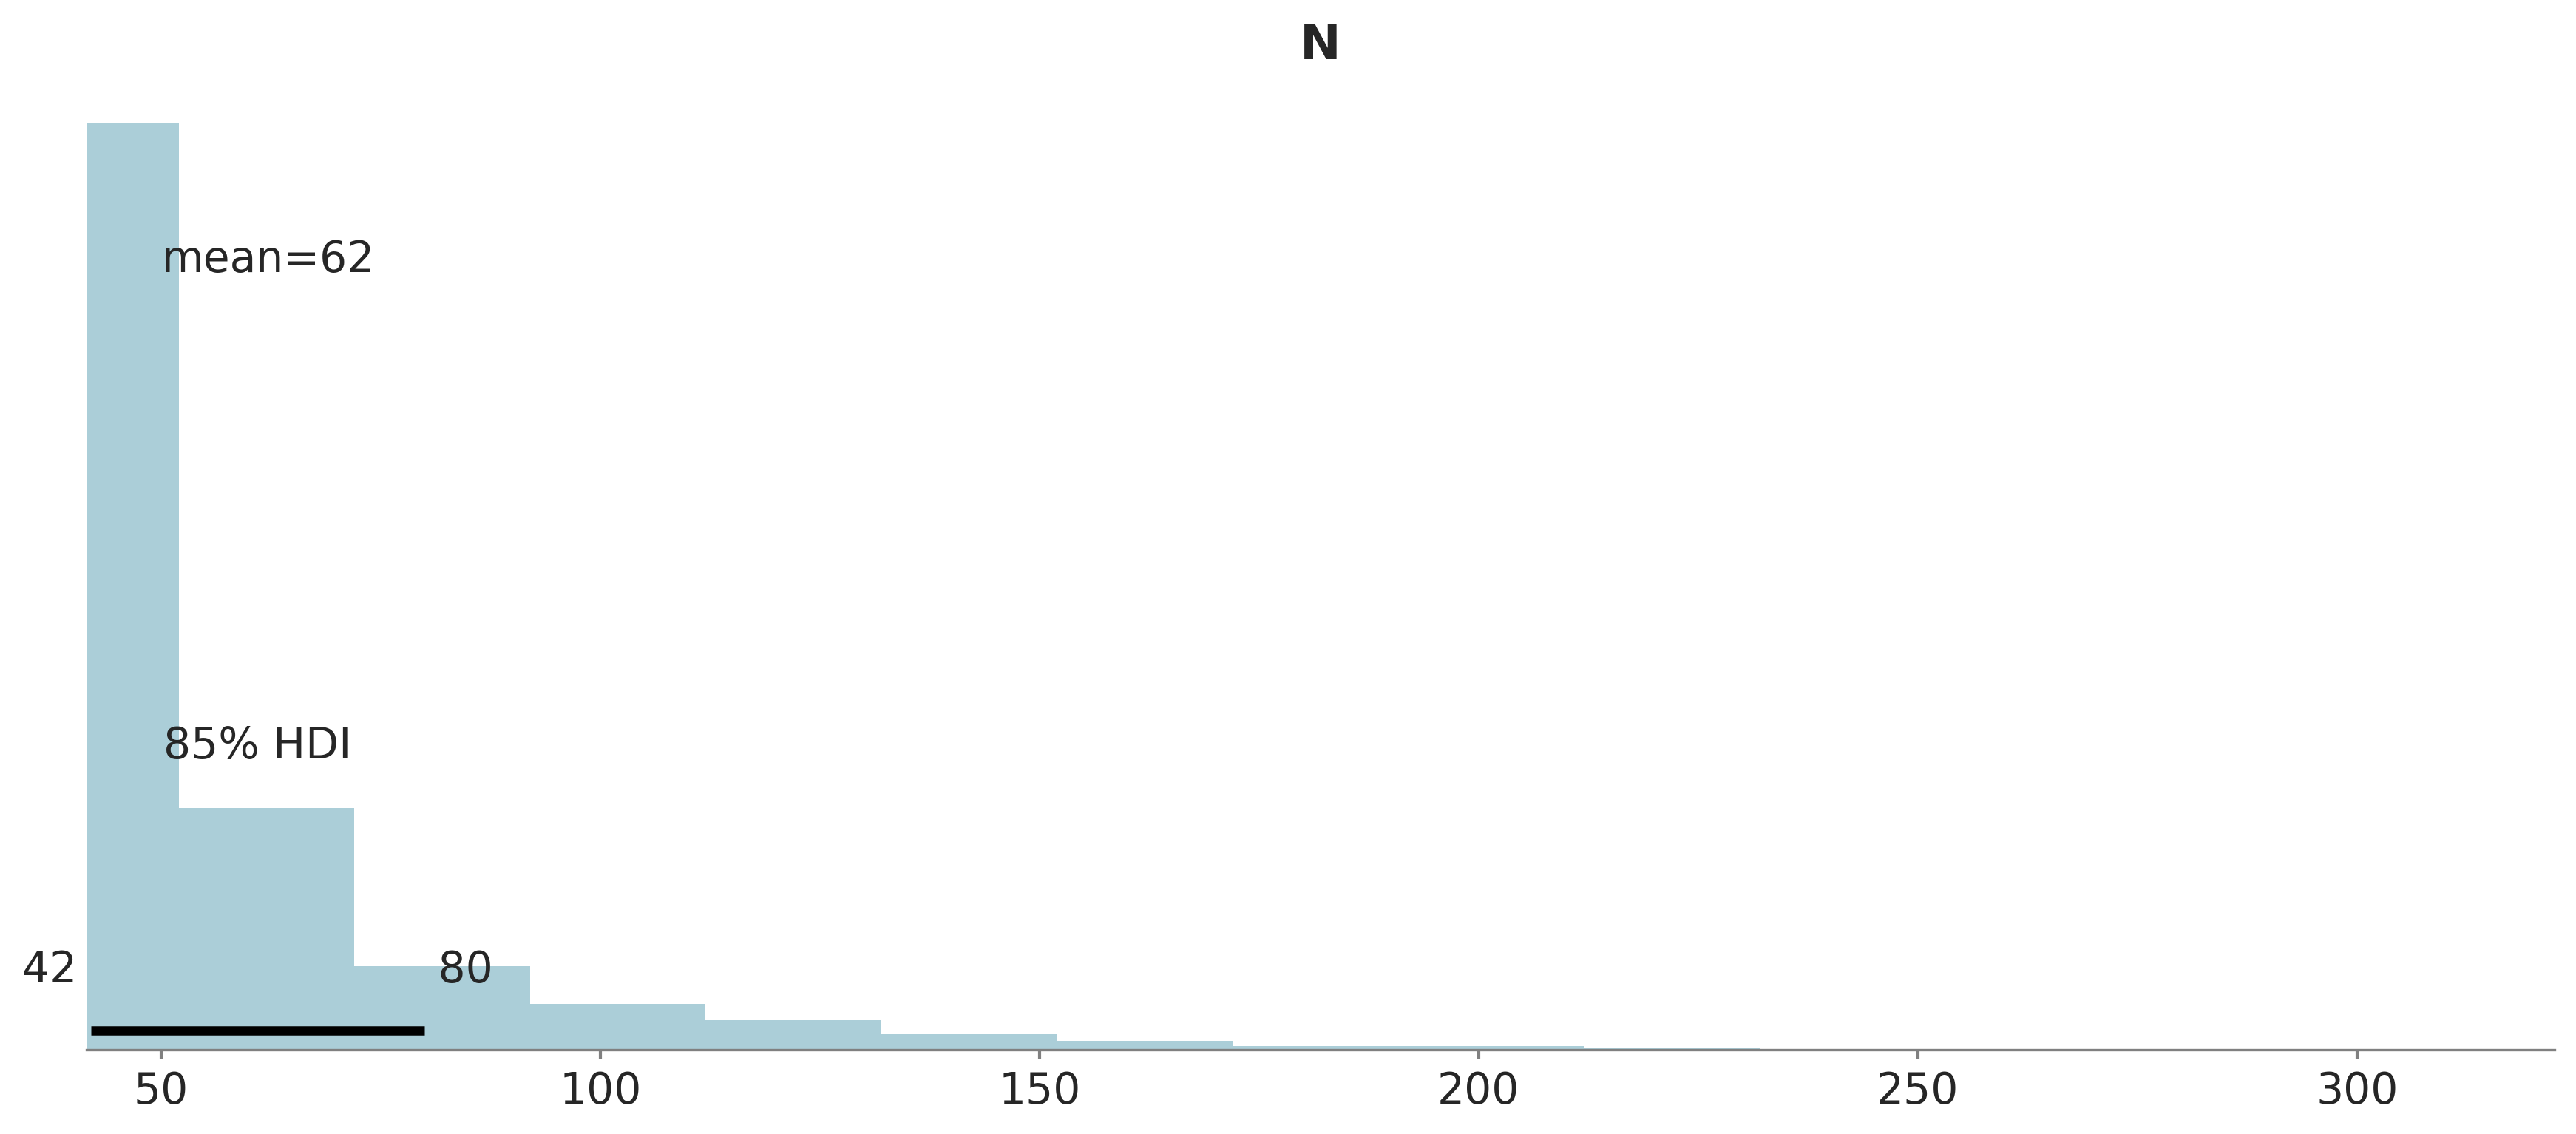

In [41]:
az.plot_posterior(idata, var_names='N', hdi_prob=0.85);

## Modelos Multiparamétricos

<br>

Prácticamente todos los modelos de interés en estadística tienen más de un parámetro.


* Los parámetros que no son de inmediato interés pero son necesarios para definir un modelo de forma completa se llaman *nuisance parameters* (o parámetro estorbo). (Ej. La varianza cuando queremos estimar la media de una distribución Gaussiana).

* Al incorporar estos parámetros permitimos que la incertidumbre que tenemos sobre ellos se propague de forma adecuada a los resultados.

### Accidentes Mineros

<br>

* Tenemos registro del número de accidentes en minas de carbón en el Reino Unido entre 1851 y 1962 ([Jarrett, 1979](http://biomet.oxfordjournals.org/content/66/1/191.abstract)).


* Queremos estudiar el efecto de las regulaciones en seguridad sobre el número de accidentes. Además estamos interesados averiguar el año en que ocurrió un cambio en la tasa de los accidentes y los valores de ambas tasas.


* Para algunos años no tenemos datos
    * Los datos faltantes $\tilde{y}$ pueden ser estimados automáticamente usando la distribución predictiva a posteriori $\int p(\tilde{y} \,|\, \theta) \, p(\theta \,|\, y) \, d\theta$:

<br>
<br>

[Documentación de PyMC](https://www.pymc.io/projects/docs/en/latest/learn/core_notebooks/pymc_overview.html#case-study-2-coal-mining-disasters)

In [42]:
accidentes = pd.Series([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6,
                        3, 3, 5, 4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5,
                        2, 2, 3, 4, 2, 1, 3, np.nan, 2, 1, 1, 1, 1, 3, 0, 0,
                        1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1,
                        0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0, 1, 1, 0, 2,
                        3, 3, 1, np.nan, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1, 4,
                        0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
años = np.arange(1851, 1962)

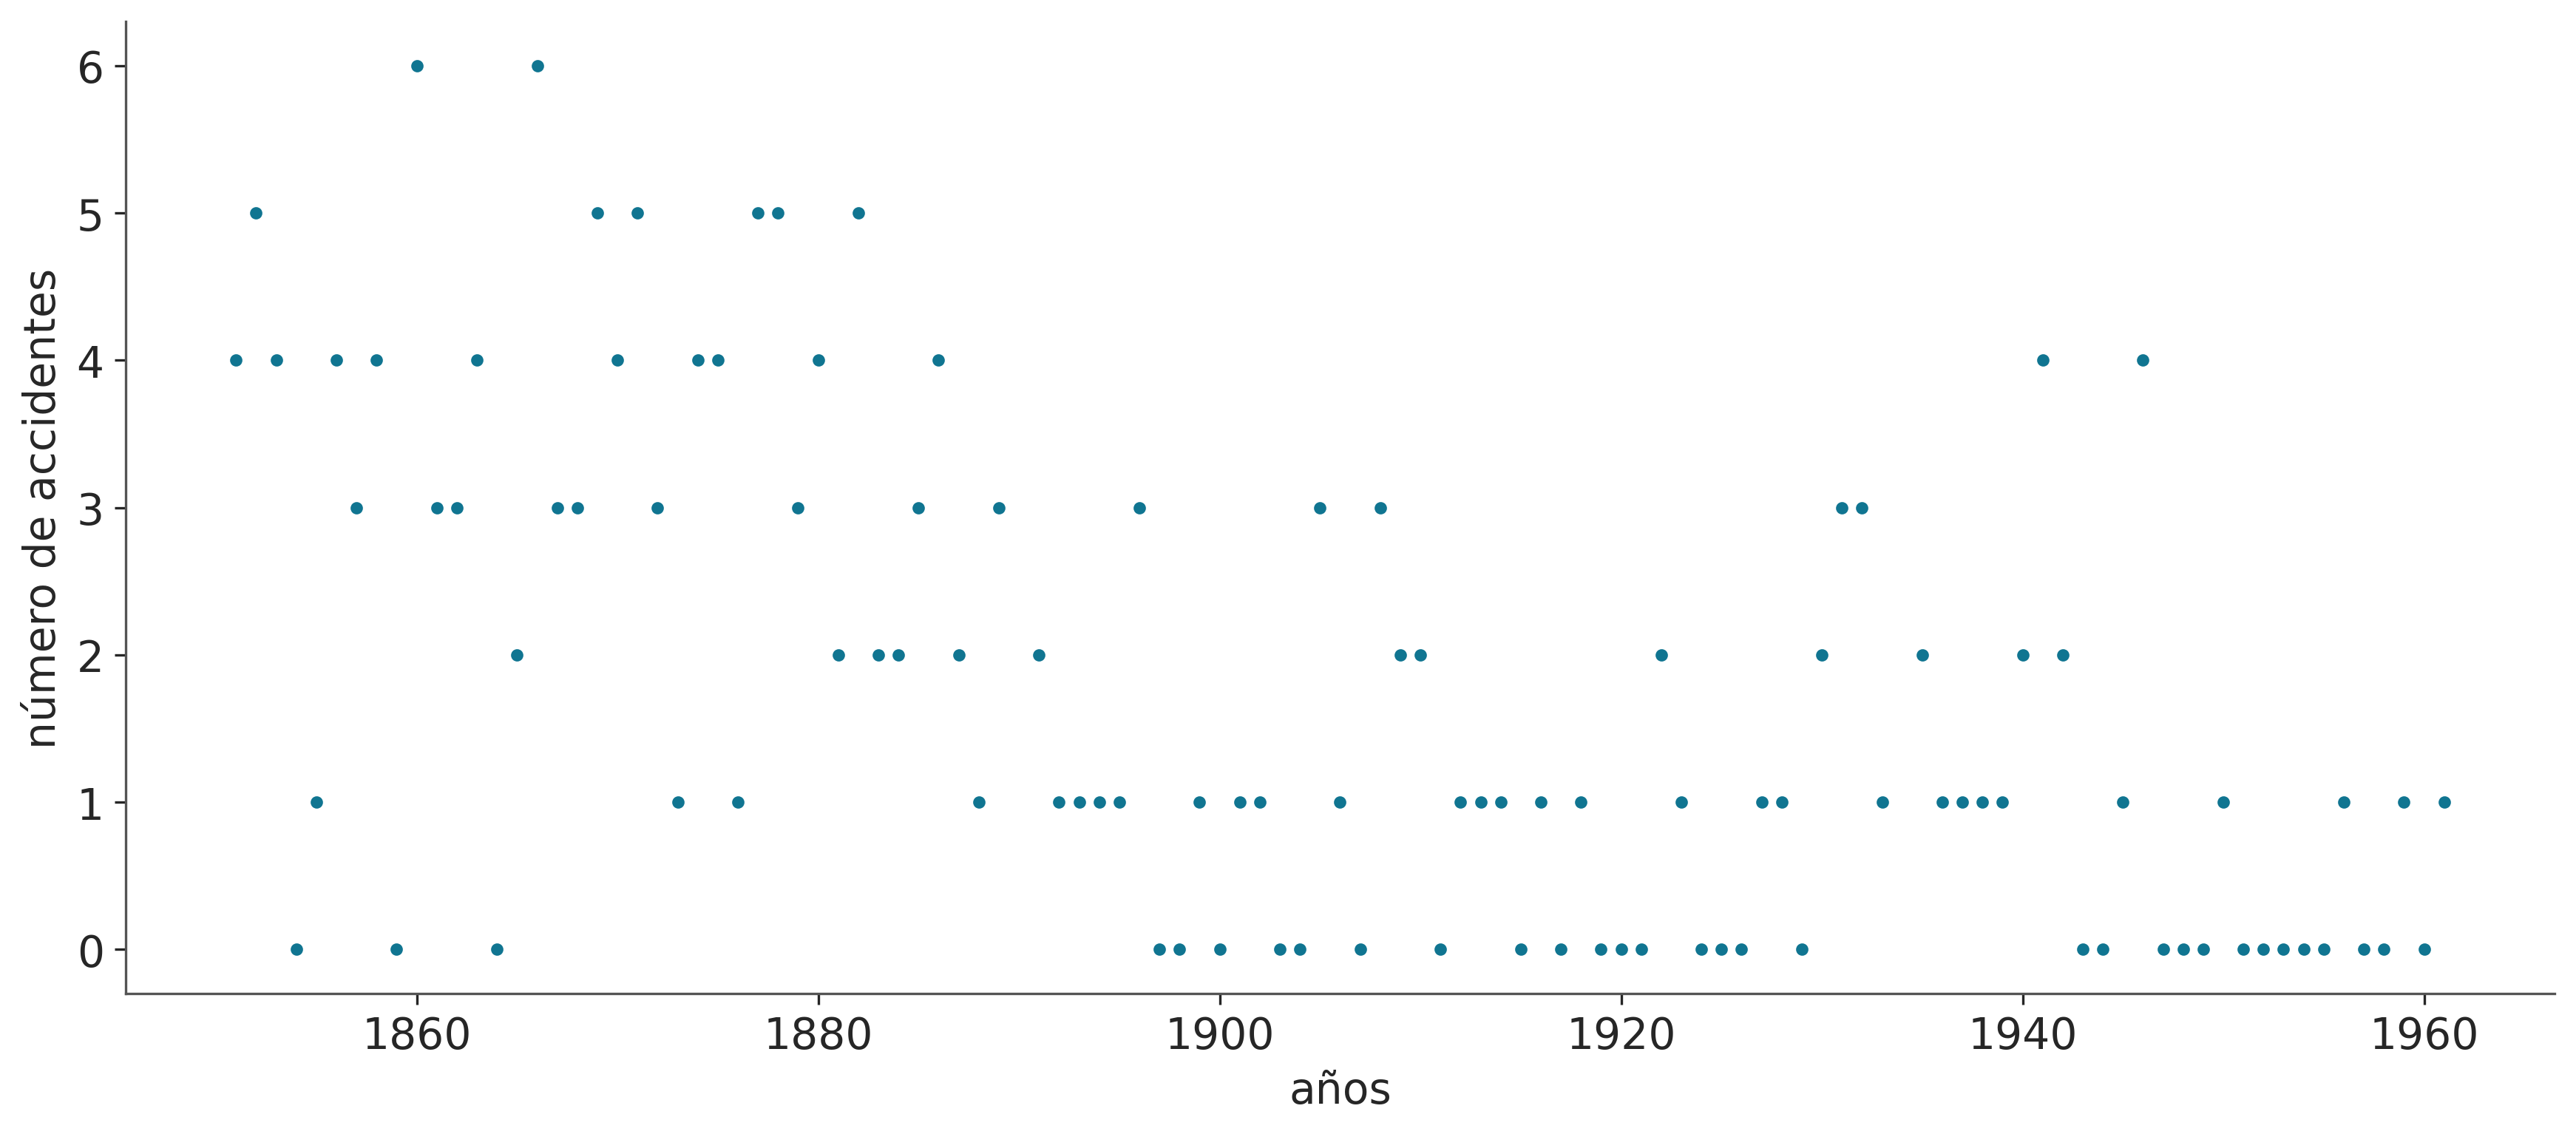

In [15]:
plt.plot(años, accidentes, '.')
plt.ylabel("número de accidentes")
plt.xlabel("años");

<center><img src="img/modelo_mineros.png" width=550></center>

\begin{equation}
y \sim Poisson(tasa)
\end{equation}

\begin{equation}
tasa = \begin{cases}
t_0, \text{if } t \ge pc,\\
t_1, \text{if } t \lt pc
\end{cases}
\end{equation}

\begin{align}
t_0 \sim Exp(\lambda) \\
t_1 \sim Exp(\lambda) \\
pc \sim DU(L, H)
\end{align}


In [16]:
with pm.Model() as modelo_cat:

    pc = pm.DiscreteUniform("pc", lower=años.min(), upper=años.max())

    # Priors para las tasas antes y después del cambio.
    t_0 = pm.Exponential("t_0", 1)
    t_1 = pm.Exponential("t_1", 1)

    # Asignamos las tasas a los años de acuerdo a pc
    tasa = pm.Deterministic("tasa", pm.math.switch(pc >= años, t_0, t_1))

    acc = pm.Poisson("acc", tasa, observed=accidentes)
    idata_cat = pm.sample(2000, random_seed=1791, idata_kwargs={"log_likelihood": True})

/home/osvaldo/anaconda3/envs/EI2/lib/python3.11/site-packages/pymc/model/core.py:1342: RuntimeWarning: invalid value encountered in cast
  data = convert_observed_data(data).astype(rv_var.dtype)
/home/osvaldo/anaconda3/envs/EI2/lib/python3.11/site-packages/pymc/model/core.py:1356: ImputationWarning: Data in acc contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [pc]
>>Metropolis: [acc_unobserved]
>NUTS: [t_0, t_1]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


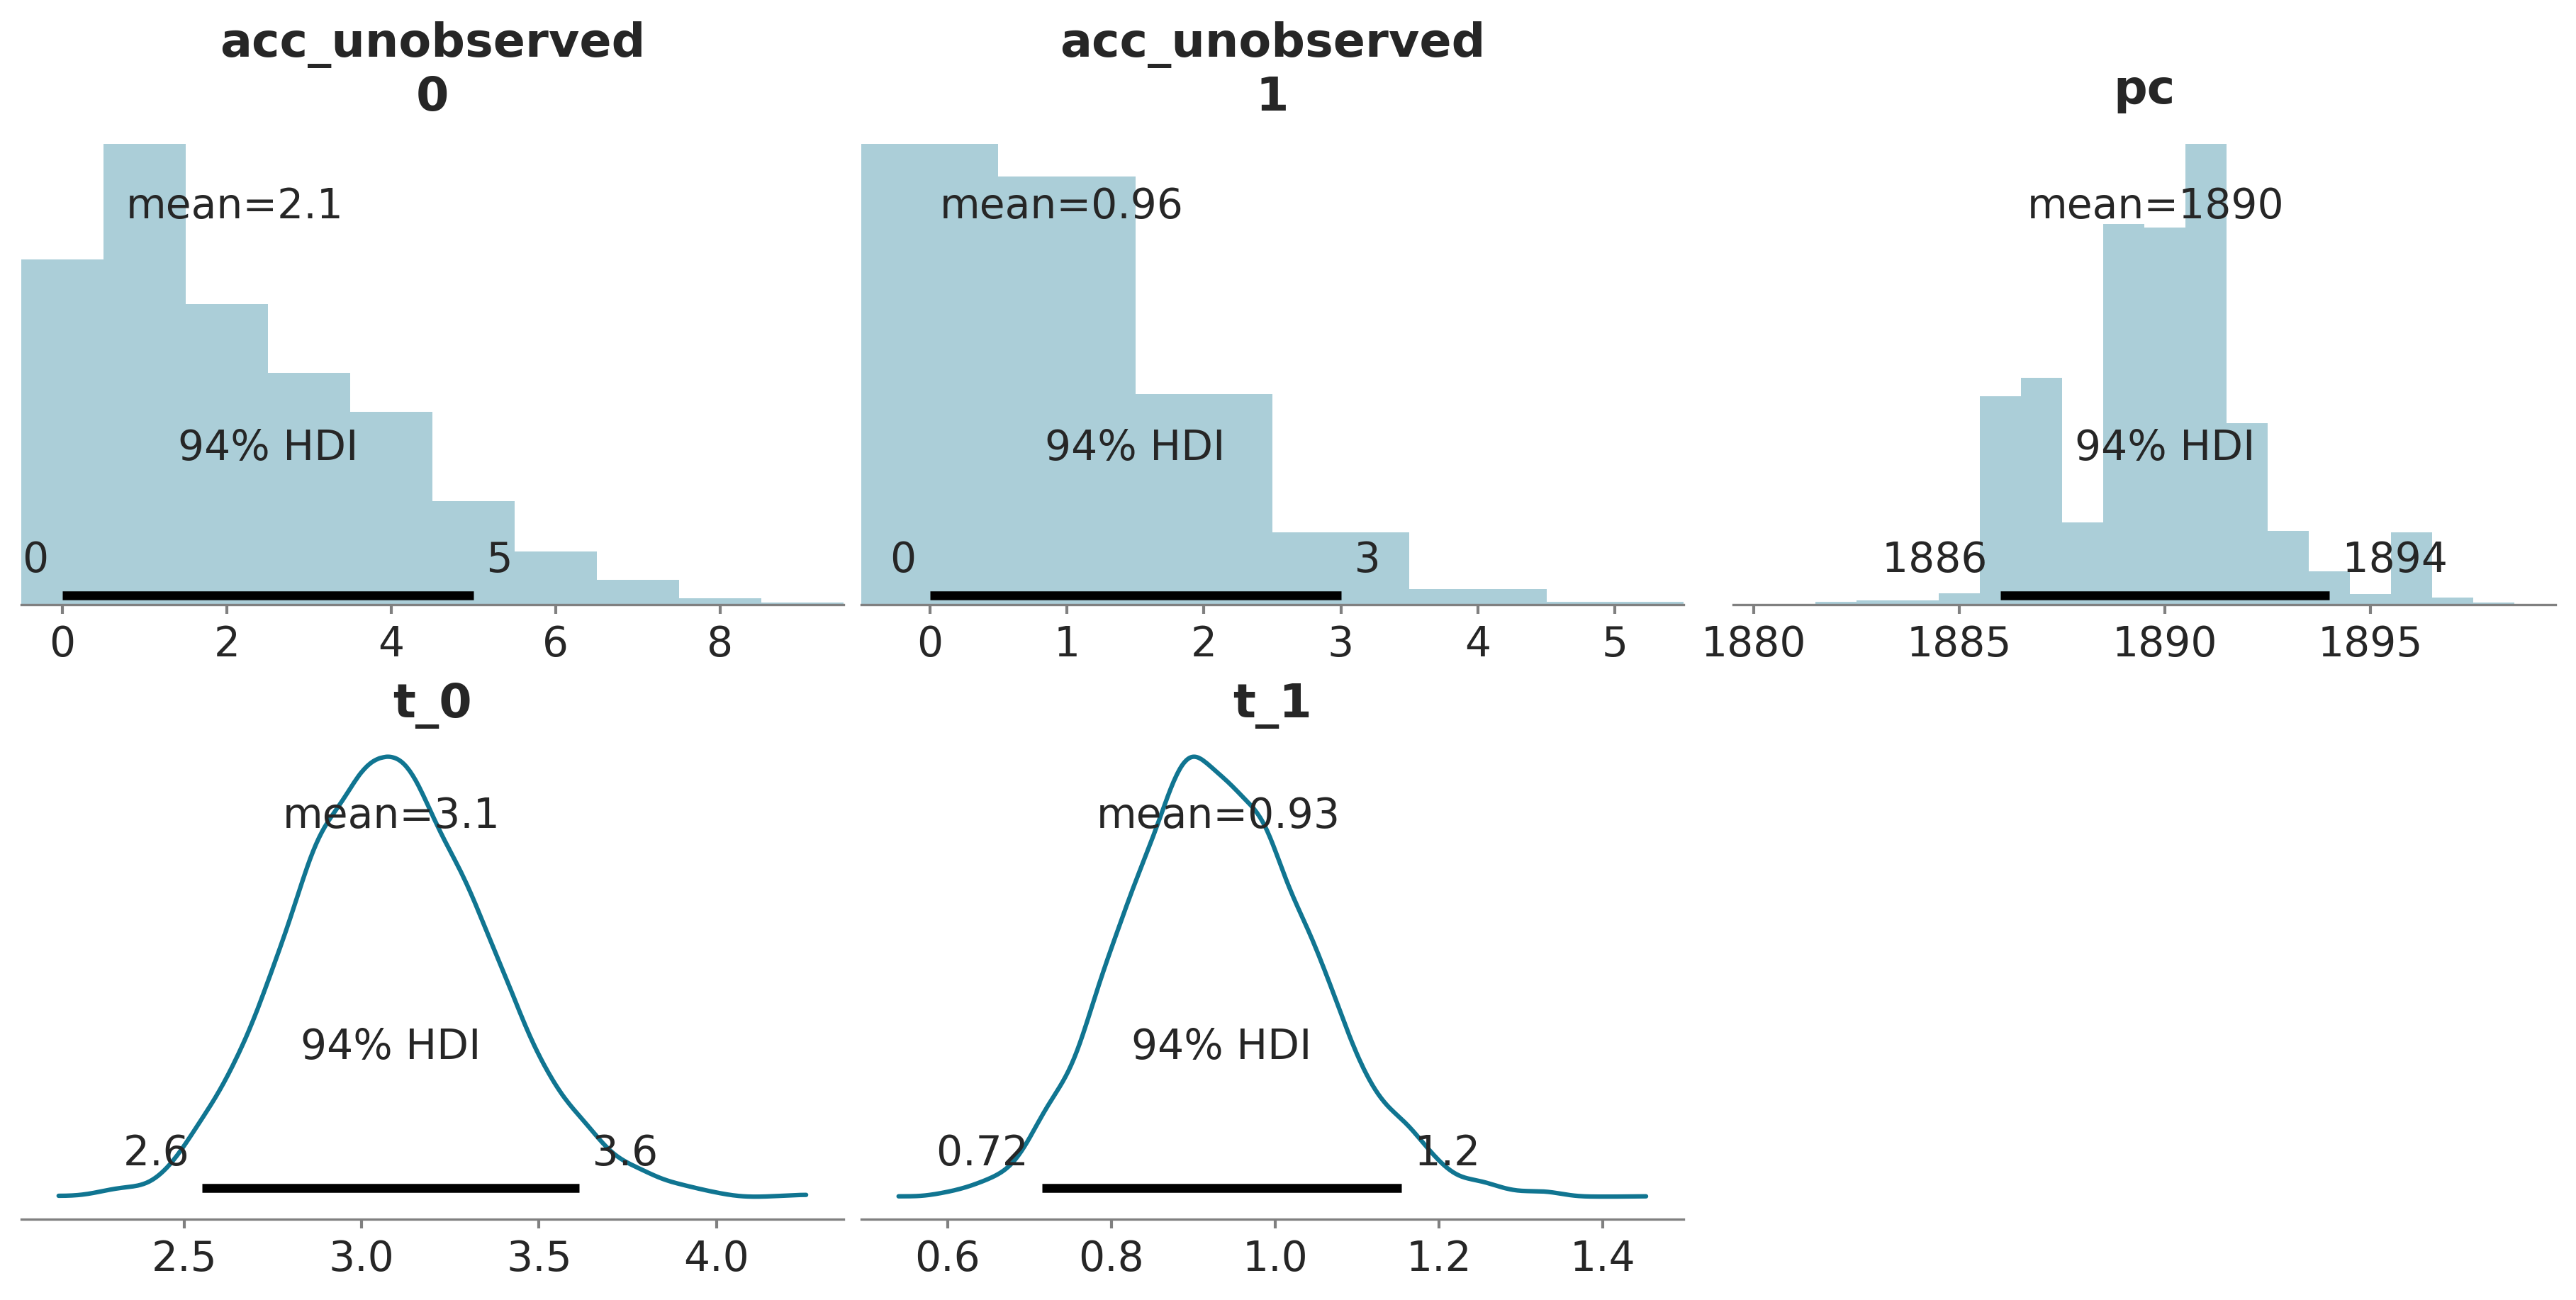

In [17]:
ax = az.plot_posterior(idata_cat, var_names=["~tasa", "~acc"], figsize=(12, 6));

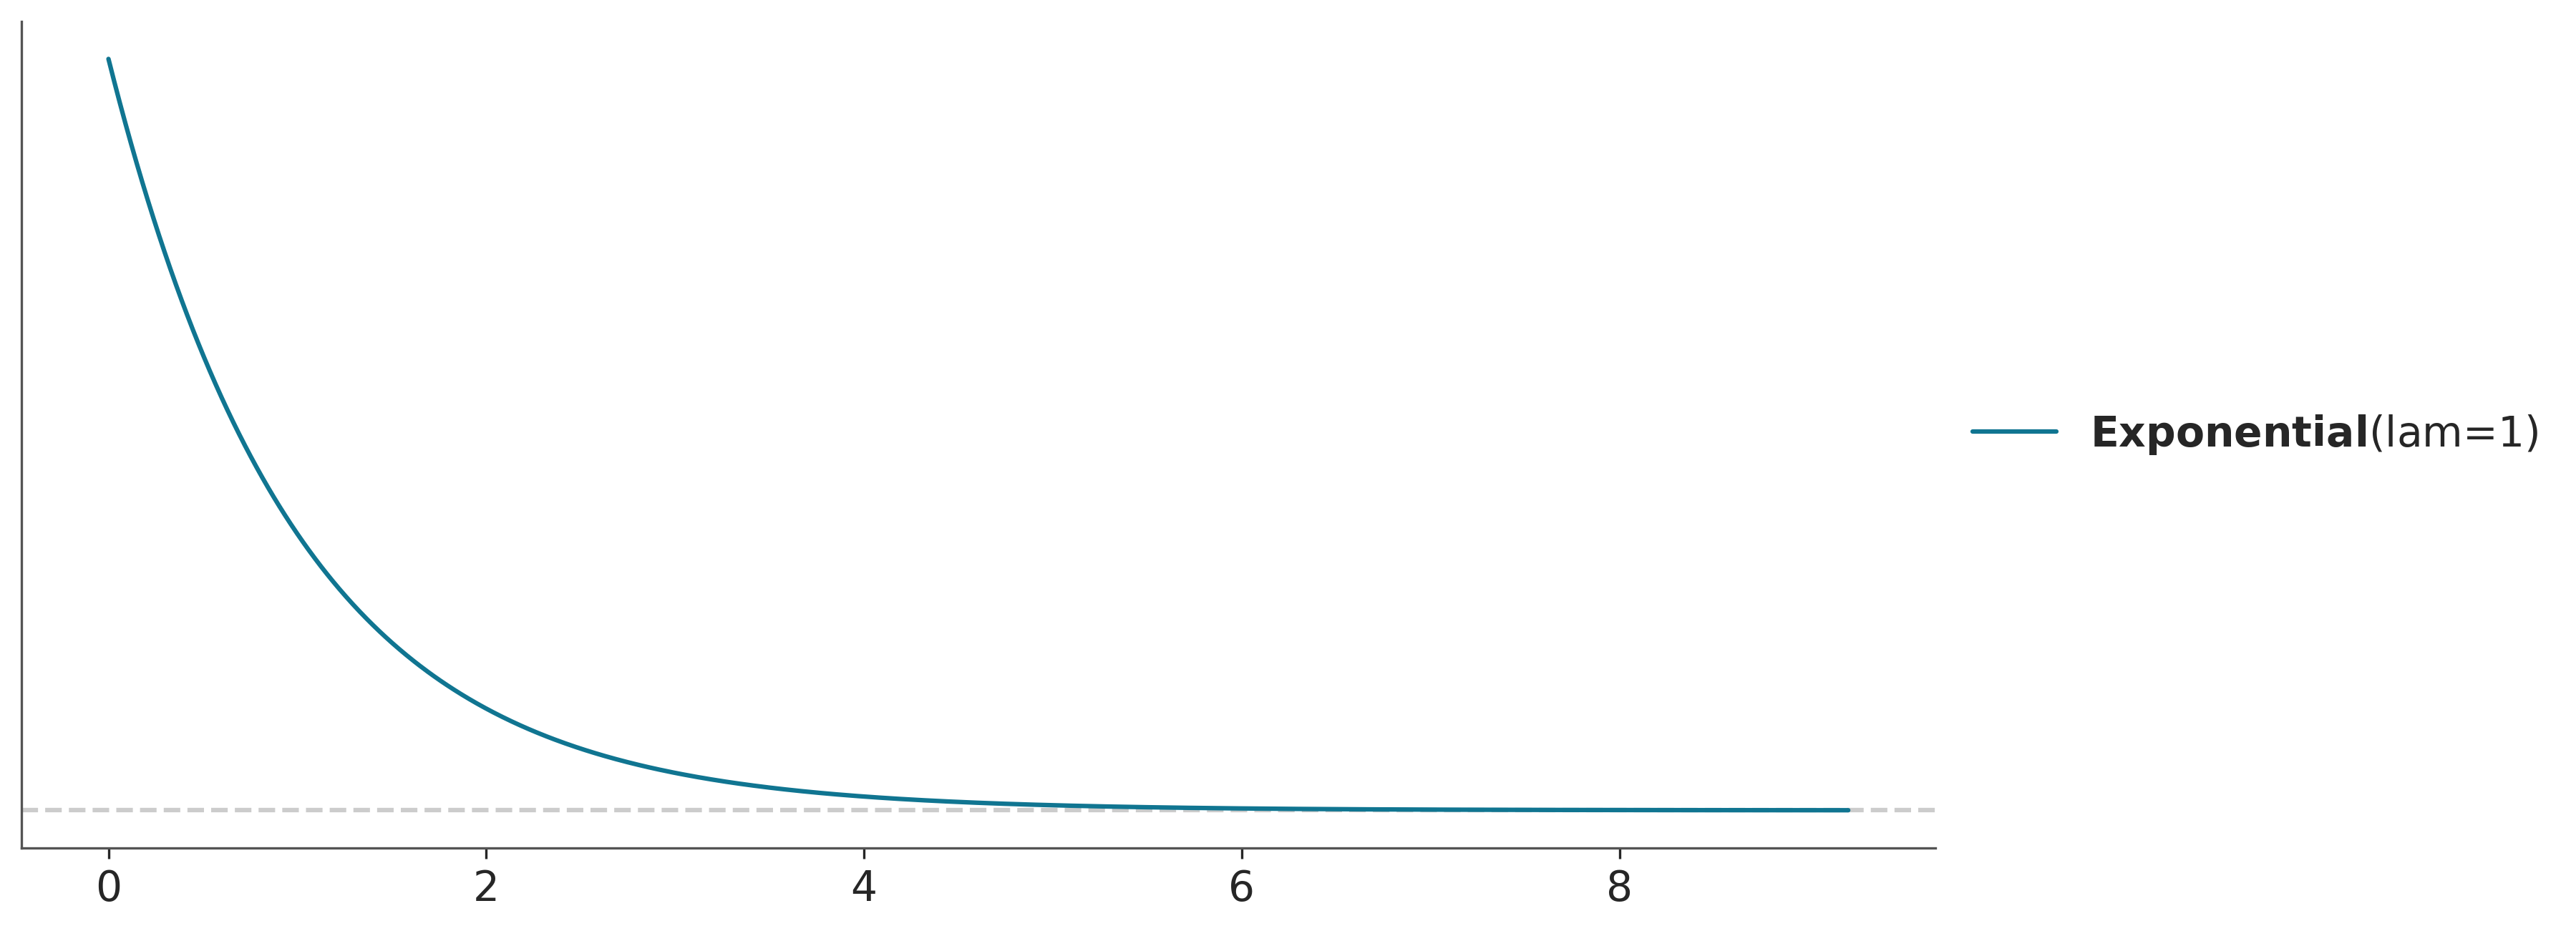

In [18]:
pz.Exponential(1).plot_pdf();

In [19]:
az.summary(idata_cat, kind="stats", var_names=["~tasa", "~acc"])

,mean,sd,hdi_3%,hdi_97%
acc_unobserved[0],2.099,1.802,0.000,5.000
acc_unobserved[1],0.962,0.983,0.000,3.000
pc,1889.781,2.443,1886.000,1894.000
t_0,3.085,0.284,2.550,3.614
t_1,0.931,0.117,0.715,1.154


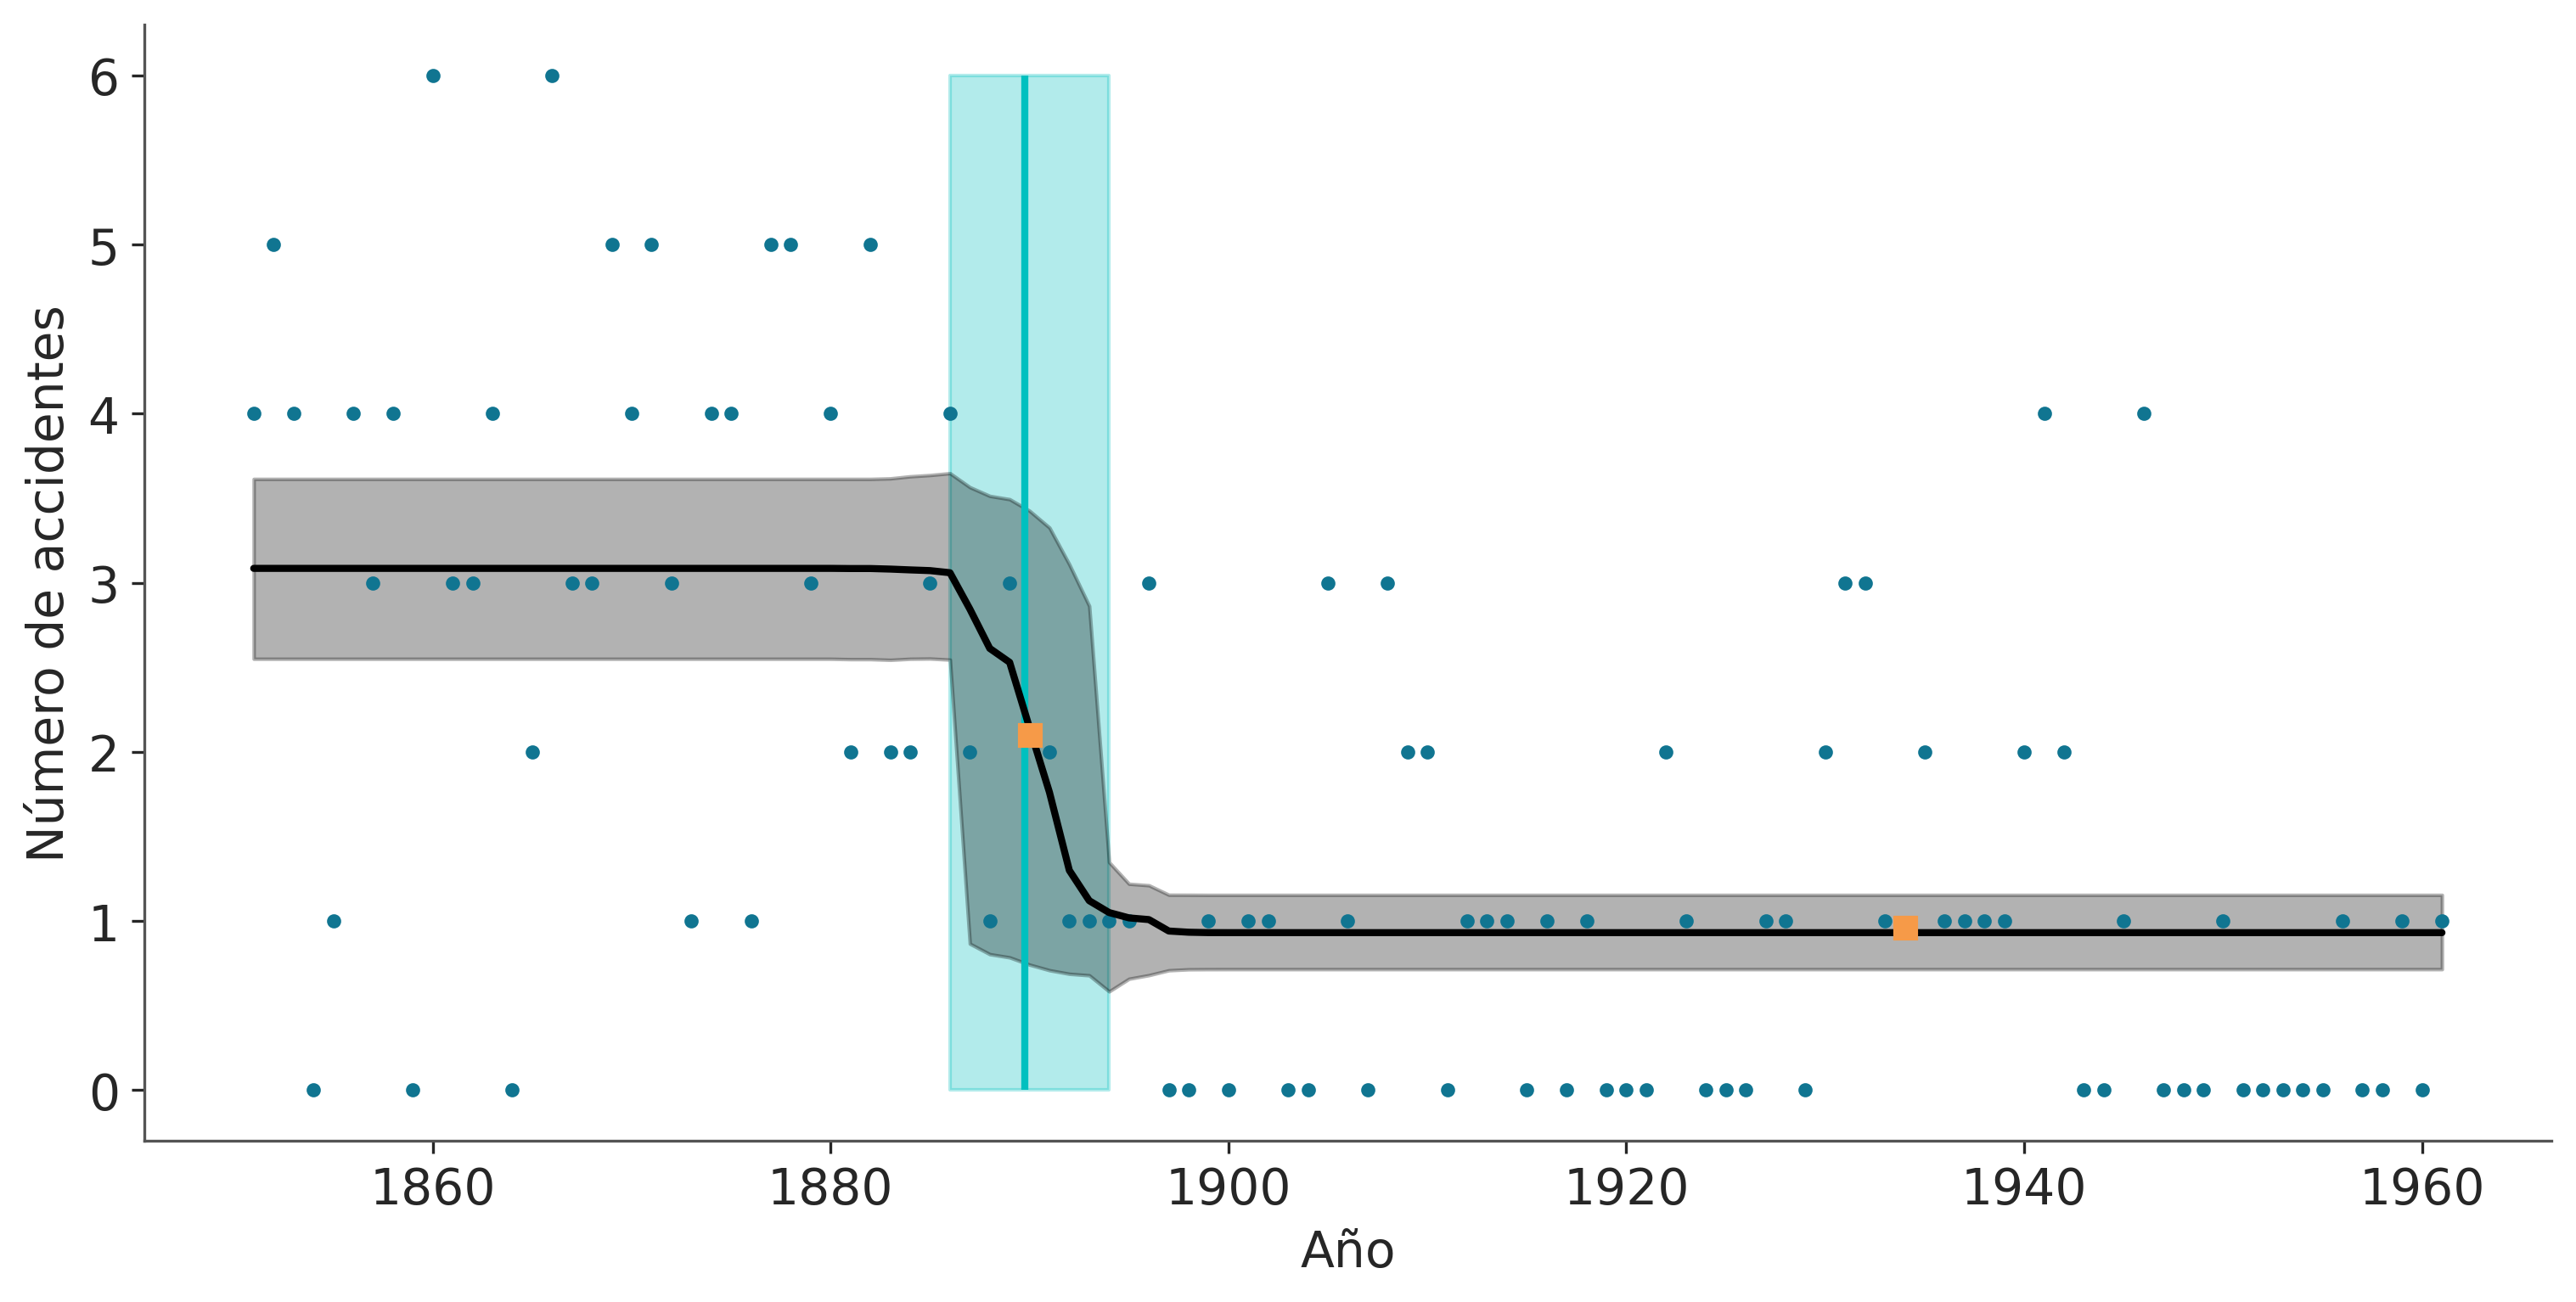

In [20]:
tasa_mean = idata_cat.posterior["tasa"].mean(("chain", "draw"))
tasa_hdi = az.hdi(idata_cat.posterior["tasa"].values)
pc_hdi = az.hdi(idata_cat.posterior["pc"])["pc"]

_, ax = plt.subplots(figsize=(10, 5), sharey=True)
ax.plot(años, accidentes, ".")

ax.set_ylabel("Número de accidentes")
ax.set_xlabel("Año")

ax.vlines(
    idata_cat.posterior["pc"].mean(("chain", "draw")),
    accidentes.min(),
    accidentes.max(),
    color="C1",
    lw=2,
)


ax.fill_betweenx(
    [accidentes.min(), accidentes.max()], pc_hdi[0], pc_hdi[1], alpha=0.3, color="C1"
)
ax.plot(años, tasa_mean, "k", lw=2)
ax.fill_between(años, tasa_hdi[:, 0], tasa_hdi[:, 1], alpha=0.3, color="k")


faltante0 = (
    idata_cat.posterior["acc_unobserved"].sel(acc_unobserved_dim_0=0).mean(("chain", "draw"))
)
faltante1 = (
    idata_cat.posterior["acc_unobserved"].sel(acc_unobserved_dim_0=1).mean(("chain", "draw"))
)

ax.plot(años[np.isnan(accidentes)], [faltante0, faltante1], "C2s");

## Comparación de grupos

<br>


* Un problema muy común en inferencia estadística es la comparación de dos (o más) grupos


* Podemos estar interesados en saber si algún valor de un grupo es más grande que el del otro grupo


* Requerimos de un modelo estadístico porque los datos provienen de mediciones con errores que nos impiden sacar conclusiones simplemente calculando las diferencias a partir de los datos observados.

###  El conjunto de datos de las propinas 

<br>


* Queremos estudiar el efecto del día de la semana sobre el monto de propina en un restaurante determinado

<br>


[Bryant, P. G. and Smith, M](https://www.amazon.com/Practical-Data-Analysis-Peter-Bryant/dp/0256238715/ref=dp_ob_title_bk)

In [21]:
tips = pd.read_csv('../datos/propinas.csv')
tips.tail()

,total_cuenta,propina,genero,fumador,dia,tiempo,cantidad
239,29.03,5.92,Hombre,No,Sab,Cena,3
240,27.18,2.00,Mujer,Si,Sab,Cena,2
241,22.67,2.00,Hombre,Si,Sab,Cena,2
242,17.82,1.75,Hombre,No,Sab,Cena,2
243,18.78,3.00,Mujer,No,Jue,Cena,2


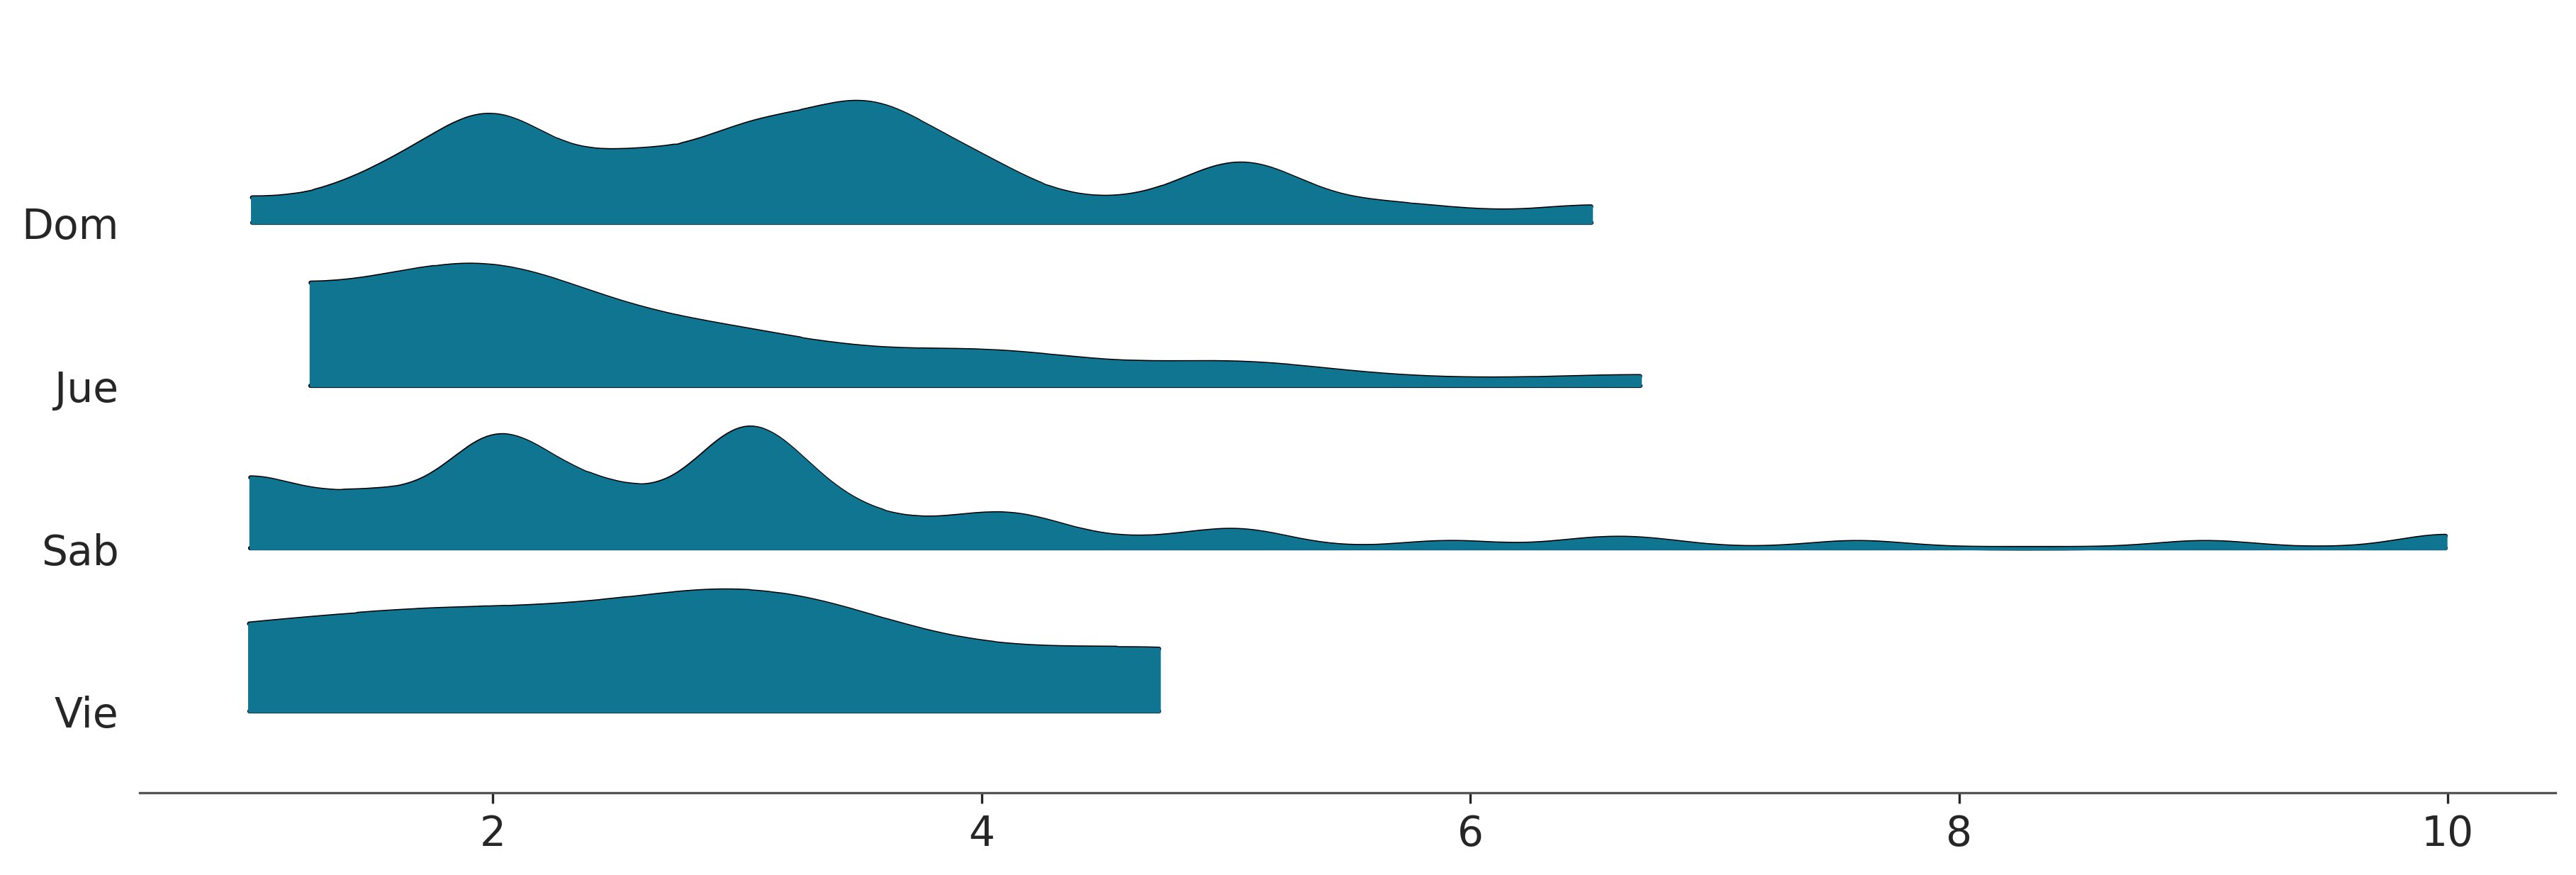

In [22]:
az.plot_forest(
    tips.pivot(columns="dia", values="propina").to_dict("list"),
    kind="ridgeplot",
    hdi_prob=1,
    figsize=(12, 4),
);

In [23]:
categories = np.array(["Jue", "Vie", "Sab", "Dom"])

tip = tips["propina"].values
idx = pd.Categorical(tips["dia"], categories=categories).codes

In [24]:
coords = {"dias": categories, "dias_flat": categories[idx]}

with pm.Model(coords=coords) as comparing_groups:
    μ = pm.HalfNormal("μ", sigma=5, dims="dias")
    σ = pm.HalfNormal("σ", sigma=1, dims="dias")

    y = pm.Gamma("y", mu=μ[idx], sigma=σ[idx], observed=tip, dims="dias_flat")

    idata_cg = pm.sample(random_seed=129)
    idata_cg.extend(pm.sample_posterior_predictive(idata_cg))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Sampling: [y]


Output()

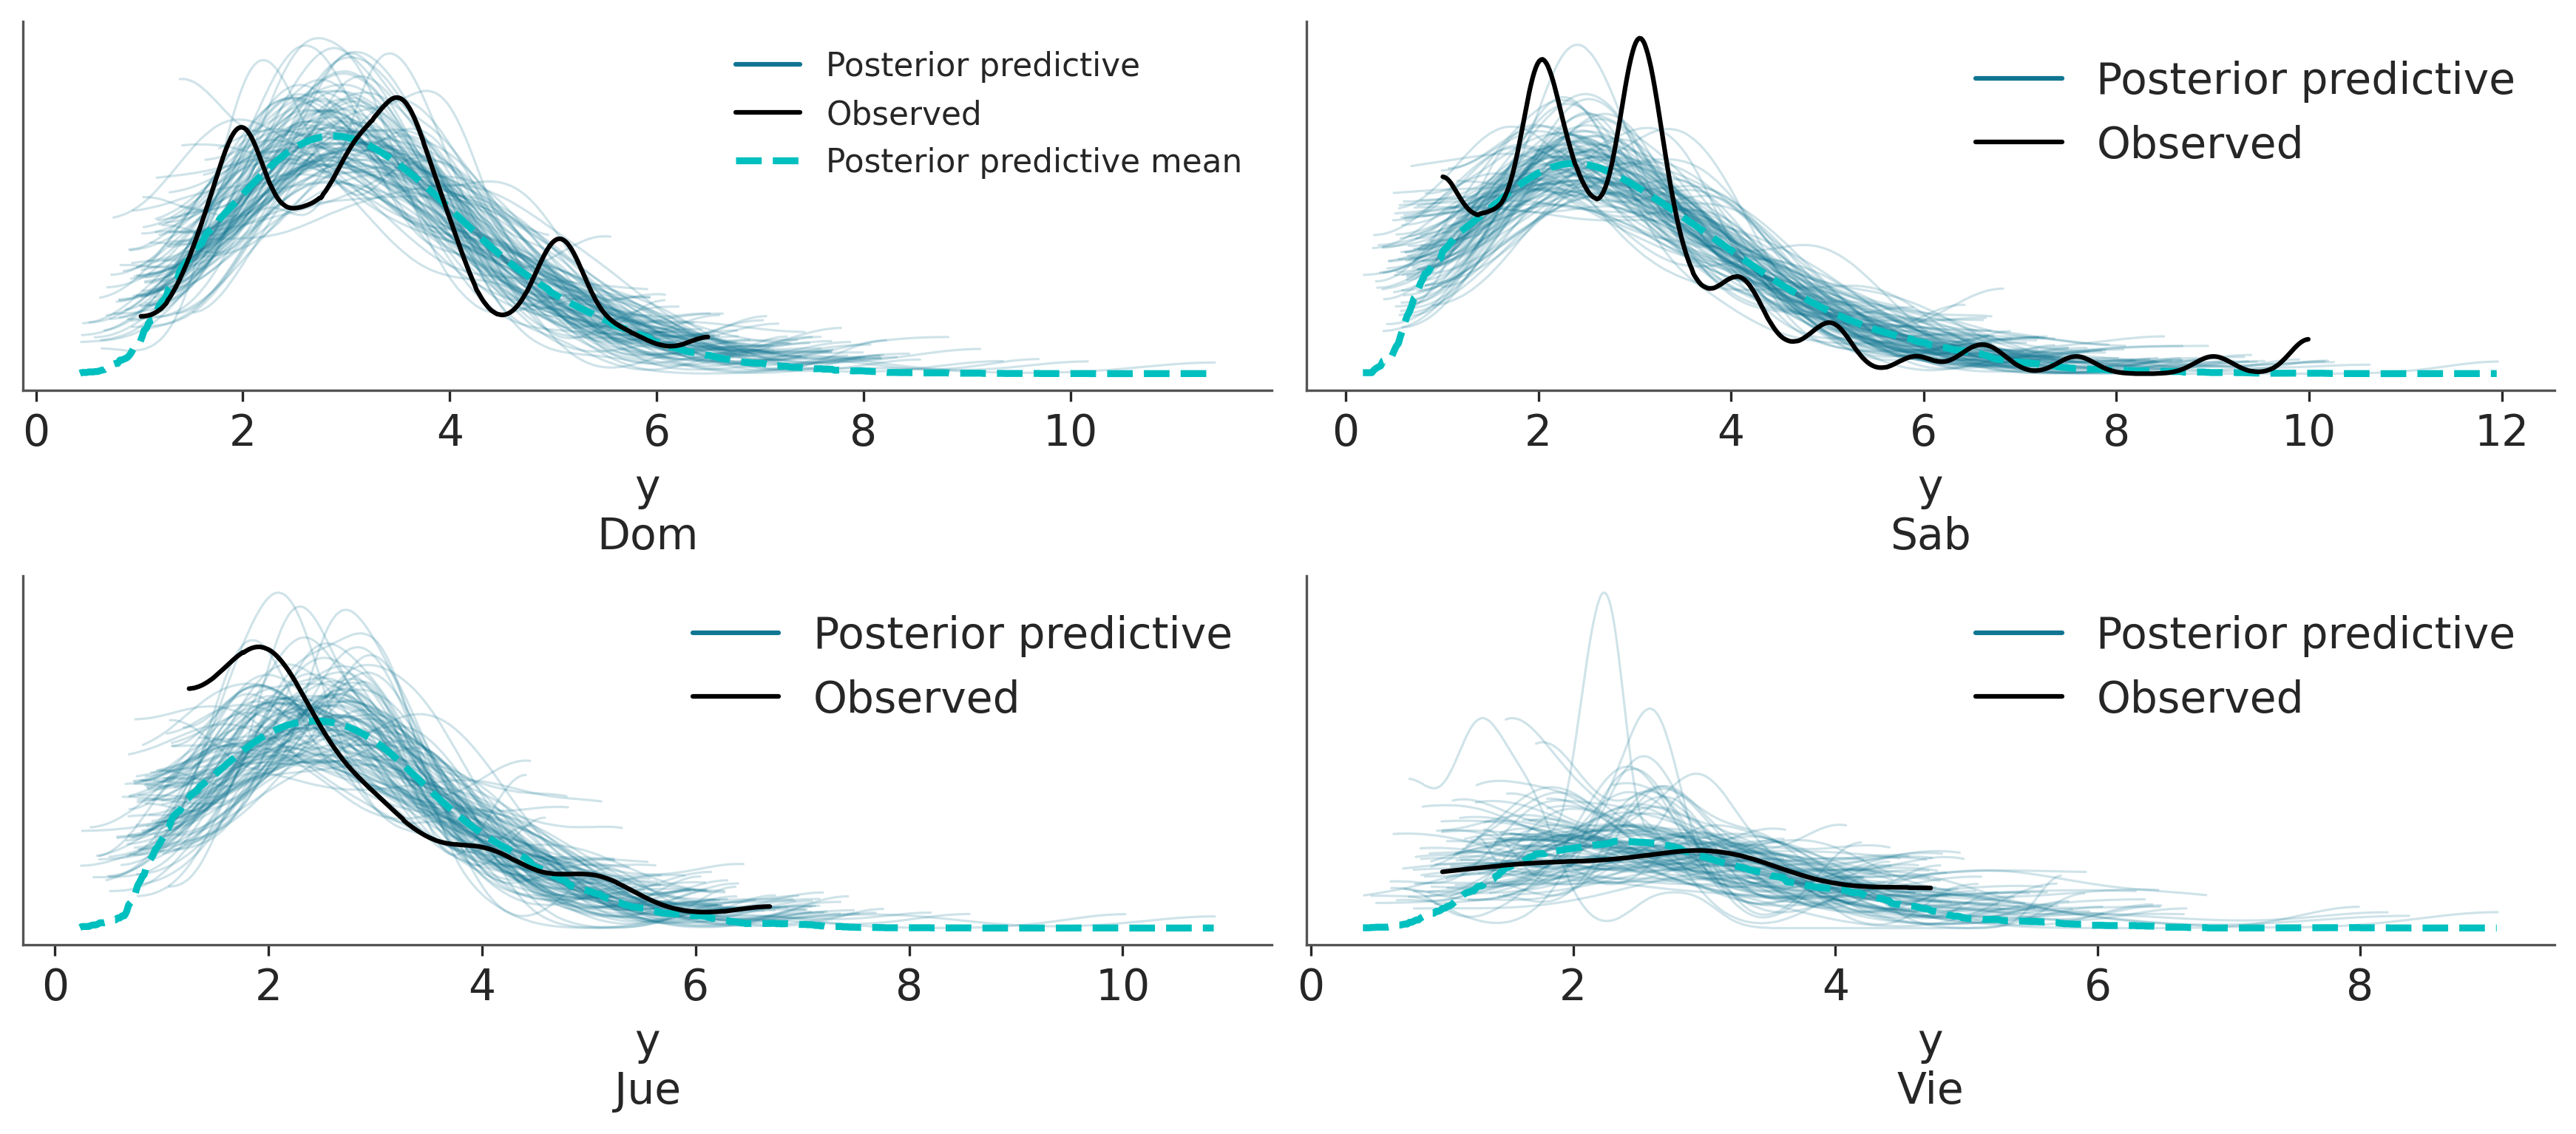

In [25]:
_, axes = plt.subplots(2, 2)
az.plot_ppc(
    idata_cg,
    num_pp_samples=100,
    coords={"dias_flat": [categories]},
    flatten=[],
    ax=axes,
);

### Tamaño del efecto

**Cohen's d**

$$
\frac{\mu_2 - \mu_1}{\sqrt{\frac{\sigma_1^2 + \sigma_2^2}{2}}}
$$

* Se puede interpretar como un *z-score*. Cuántas desviaciones estándar una media de un grupo está por encima (o por debajo) de la media del otro grupo
* [Ejemplo interactivo](http://rpsychologist.com/d3/cohend)

**Probabilidad de superioridad**

* La probabilidad que un dato tomado de un grupo sea mayor que la de un dato tomado del otro grupo.
* Si suponemos que los datos se distribuyen normalmente, entonces:


$$
ps = \Phi \left ( \frac{\delta}{\sqrt{2}} \right)
$$


$\Phi$ es la `cdf` de una distribución normal $\delta$ es el valor del Cohen's d.

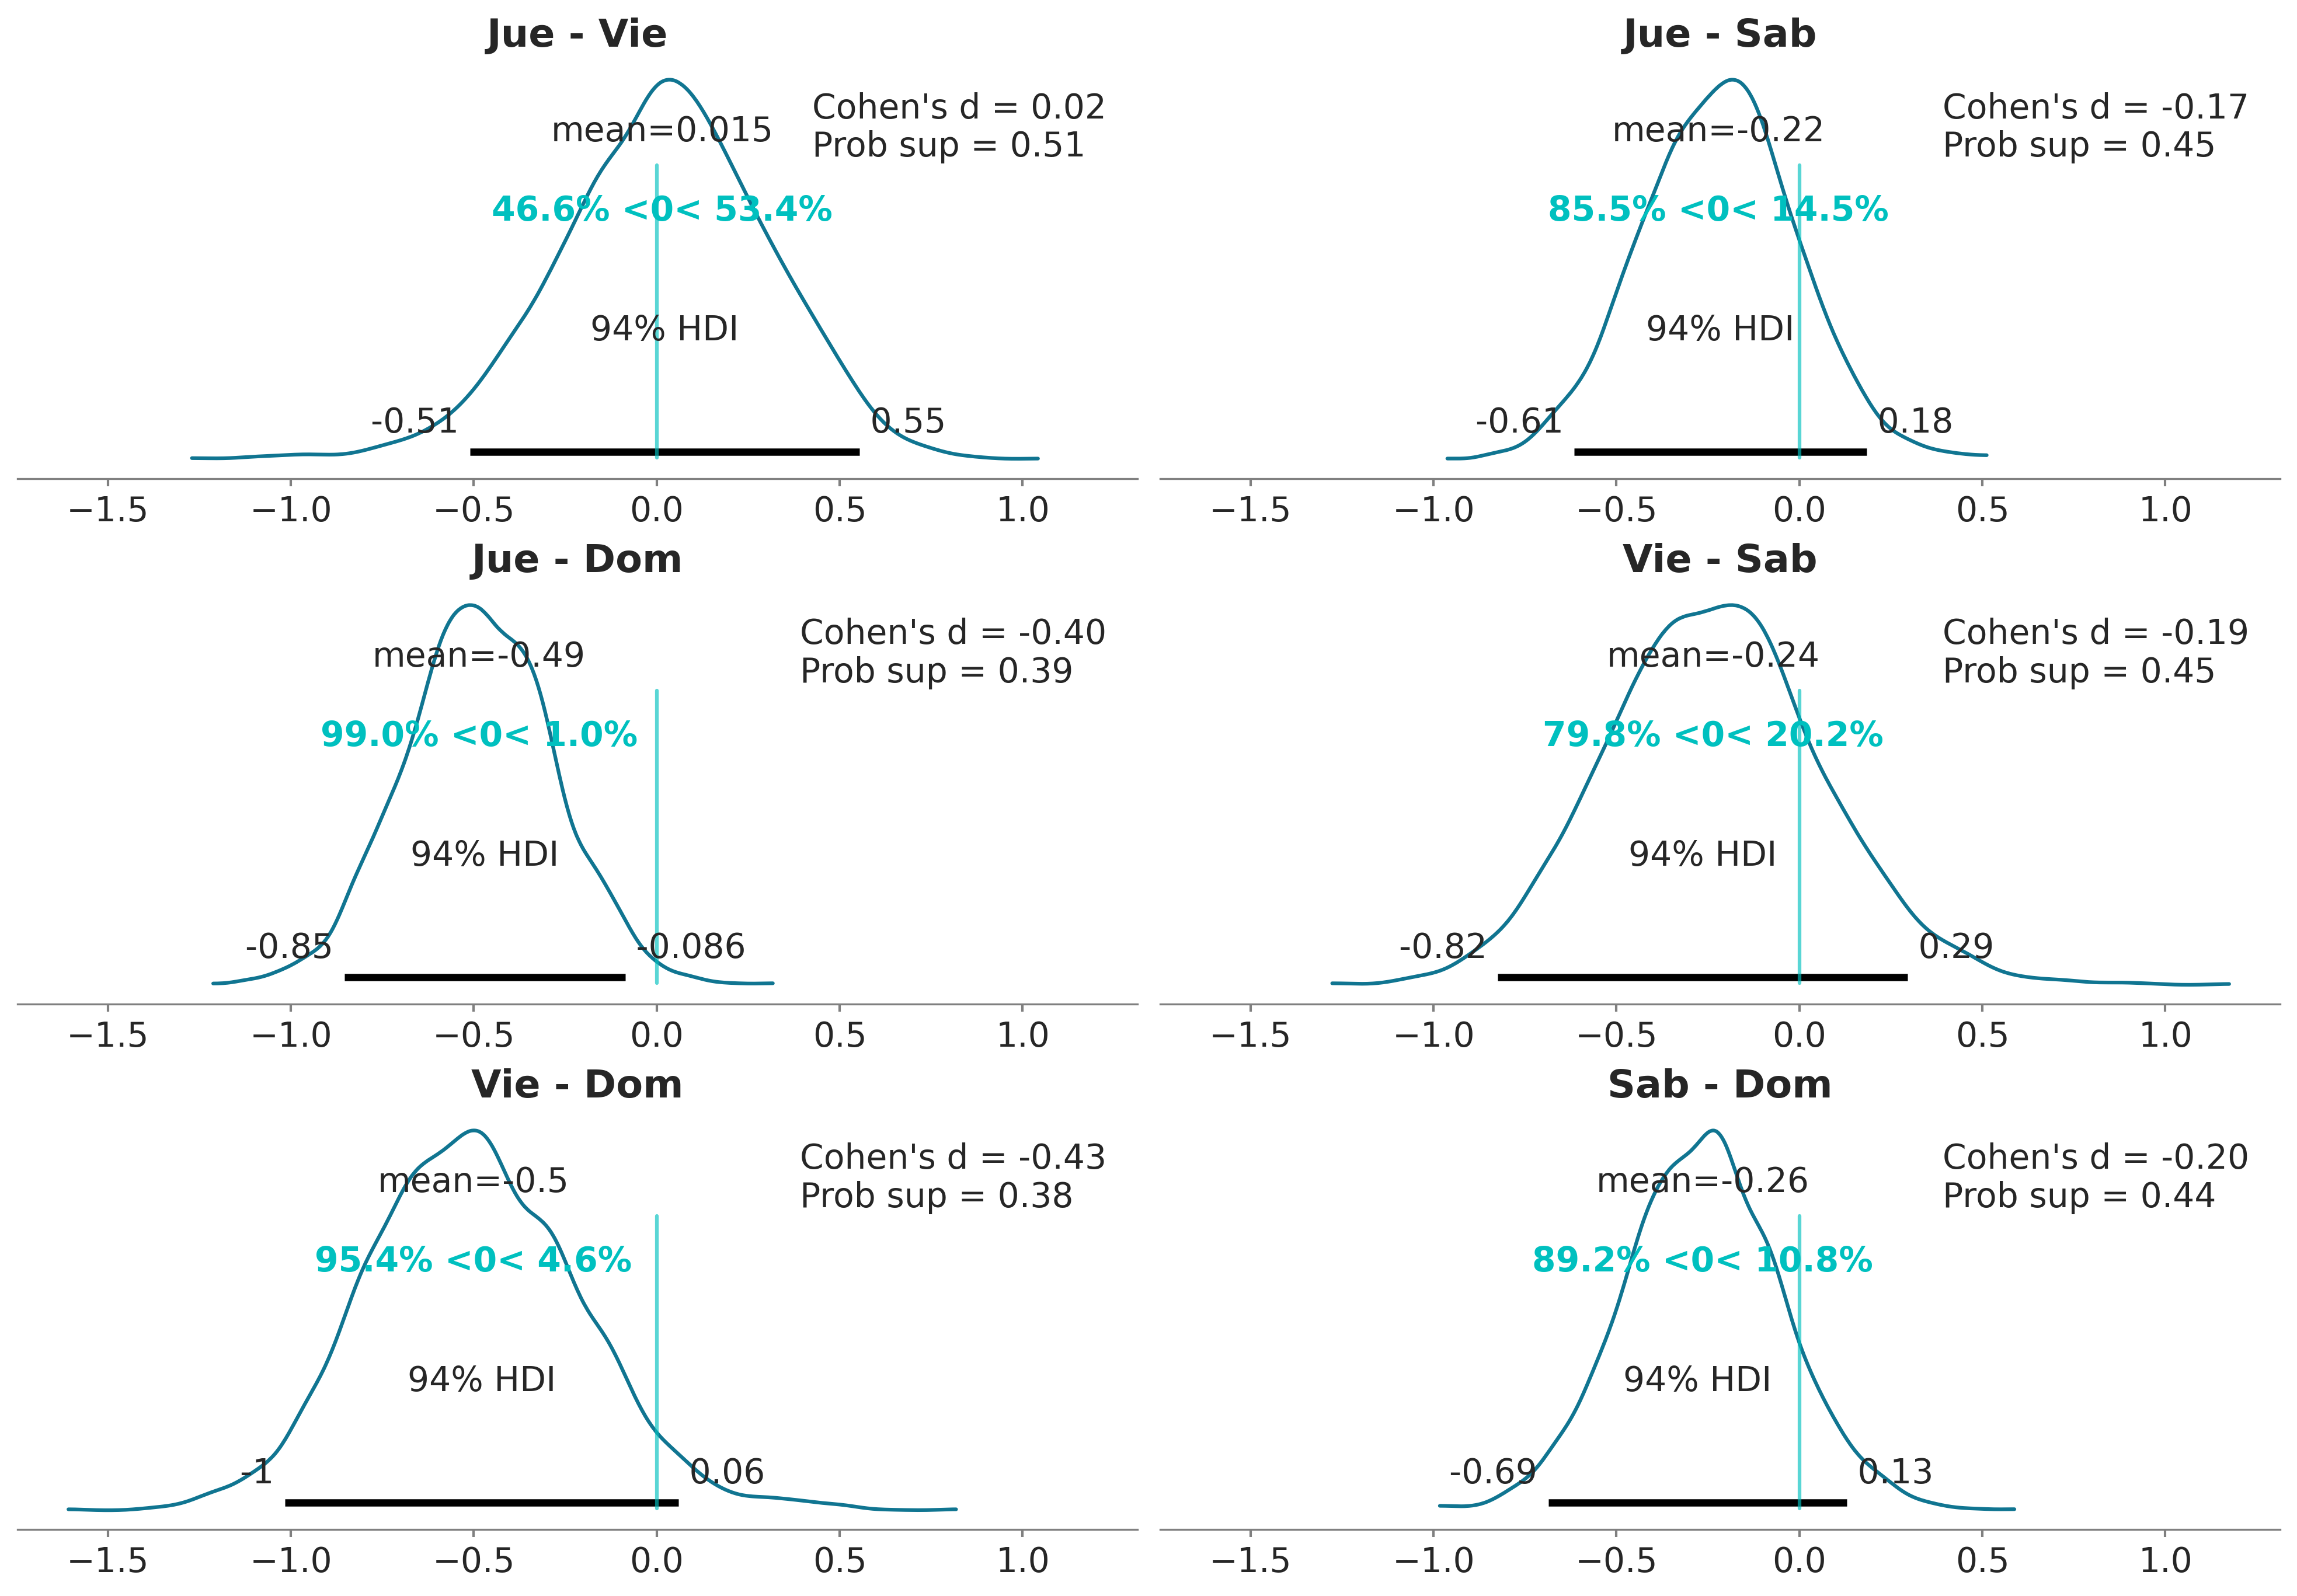

In [26]:
cg_posterior = az.extract(idata_cg)

dist = pz.Normal(0, 1)

comparisons = [(categories[i], categories[j]) for i in range(4) for j in range(i+1, 4)]

_, axes = plt.subplots(3, 2, figsize=(13, 9), sharex=True)

for (i, j), ax in zip(comparisons, axes.ravel()):
    means_diff = cg_posterior["μ"].sel(dias=i) - cg_posterior['μ'].sel(dias=j)
    
    d_cohen = (means_diff /
               np.sqrt((cg_posterior["σ"].sel(dias=i)**2 + 
                        cg_posterior["σ"].sel(dias=j)**2) / 2)
              ).mean().item()
    
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff.values, ref_val=0, ax=ax)
    ax.set_title(f"{i} - {j}")
    ax.plot(0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax.legend(loc=1)